# Exam Machine Learning with Python

Submitted by : 

Dries Luts (dries-luts@hotmail.com)<br />
Bino Maiheu (binomaiheu@gmail.com)<br />
Marijke Van De Steene (marijkevandesteene@hotmail.com)<br />

This notebook is submitted by the group above for the course exam "Machine Learning with Python", taught by Bart Van Rompaye. Course IPVW-
ICES 2024, **due date**: 2024-07-03 23:59. 

Source code as well as lists of issues are centralised in a github repository under https://github.com/Marijkevandesteene/MachineLearning, forked by Dries Luts and Bino Maiheu fore contributions. This notebook is a consolidation of investigation and work down by the group in seperate notebooks. The notebook serves both as the submission of the code for the exam as also the technical report for the exam.

# Changelog

- **2024-06-05** [MV] : Initial version
- **2024-06-06** [BM] : Consolidated structure, imported initial analysis from notebooks 
- **2024-06-18** [BM] : Consolidated structure: Walkthrough in team / Finalized data preparation
- **2024-06-18** [MVDS] : Added data preparation steps on score
- **2024-06-19** [BM] : Fixed issue w.r.t kNN imputer to apply for score
- **2024-06-23** [MVDS] : Random forest model tuning, Calibration / applied explainability / removed some try out code
- **2024-06-28** [BM] : Added Gradient Booster + consolidation of notebook
- **2024-06-28** [DL] : Added SVM approaches + basic logistic/linear regression + cleaning of the notebook



# Initialisation

## Packages

In [1]:
# -- Importing packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle
import joblib

from pathlib import Path

In [84]:
# -- Import Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder  # for preprocessing & scaling
from sklearn.impute import KNNImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.ensemble import RandomForestRegressor  # Random Forest for classification
from sklearn.ensemble import GradientBoostingRegressor  # GBM for classification
from sklearn import svm # SVM for classification
from imblearn.over_sampling import RandomOverSampler  # Synthetic upsampling

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from sklearn import linear_model

from sklearn.metrics import recall_score

In [4]:
# -- Import Defined functions
import funcs.common_used_functions as cuf

## Notebook setup

In [5]:
# -- Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [6]:
# -- Jupyter magic command to show plots inline immediately
%matplotlib inline

In [7]:
# -- Setting seed
seed = 43
np.random.seed(seed)

In [8]:
# -- pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing datafiles

In [9]:
# -- Loading the dataset for scoring Russian hotel guests
data_file_path = Path('input')  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

train_filename = data_file_path / 'train_V2.csv'
score_filename = data_file_path / 'score.csv'
dict_filename = data_file_path / 'dictionary.csv'

# -- Training & scoring data
train_V2 = pd.read_csv(train_filename)
score = pd.read_csv(score_filename)

# -- We load the dictionare as a dict
#    Note that small edits were made to the original file 
#    - tenure_yrs occurred twice, this was corrected
#    - income_am did not occur, was added...
dictionary = pd.read_csv(dict_filename, sep=';', header=None).set_index(0).to_dict(orient="dict")[1]

# -- Some feedback 
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


First inspection of the training data.

In [11]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


We first analyse some high level stuff regarding the loaded data.

In [12]:
# -- print list of features
print('Training set features : ')
print(train_V2.columns)

Training set features : 
Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')


In [13]:
# -- compare the feaures in the training & score sets
print("Features in the training set but not in the scoring set (target variables) : ")
set(train_V2.columns).difference(set(score.columns))

Features in the training set but not in the scoring set (target variables) : 


{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

In [14]:
# -- Adding an index to the 
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

score.insert(0, 'Id', range(0, 0 + len(score)))
if 'Id' in score.columns:
    score = score.set_index('Id')


In [15]:
# -- Print some info
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

# Dataset preparation

Ok, now that we have our data loaded, lets dive into the analysis.  In this section we shall check for consistency, handle missing values, outliers etc... We first start  with extracting categorical and numerical features

## Extraction of categorical and numerical features

It's not clear immediately what the categorical and numerical features are in the dataset, this is important for later on (e.g. imputation of missing values), so we spend a little time analysing this. 

Here we aim to get a list of feature names (i.e. column names) one with categorical features, one with numerical features

In [16]:
# -- test the number of unique values in the dataframe
train_nunique = train_V2.nunique()
train_nunique

income_am                2109
profit_last_am           1452
profit_am                2139
damage_am                 616
damage_inc                 11
crd_lim_rec                41
credit_use_ic               2
gluten_ic                   2
lactose_ic                  2
insurance_ic                2
spa_ic                      2
empl_ic                     2
cab_requests               17
married_cd                  2
bar_no                     47
sport_ic                    2
neighbor_income          3042
age                        72
marketing_permit            2
urban_ic                    2
dining_ic                   2
presidential                2
client_segment              6
sect_empl                   6
prev_stay                   2
prev_all_in_stay            2
divorce                     2
fam_adult_size              4
children_no                 7
tenure_mts                586
tenure_yrs                 58
company_ic                  2
claims_no                  10
claims_am 

In [17]:
# train_nunique[ train_nunique == 2 ]

We see quite some variables with only 2 unique values, and from looking at the dictionary, those likely will be binary features : true/false. 

Additionally, we see that the features `client_segment` as well as `sect_empl` also only contain 6 unique values and from the dictionary (client and employment sectors), it is safe to assume that those features are also categorical. Some additional features also contain a limited amount of unique values, however, judging from the dictionary those should not be considered categorical : 
- `fam_adult_size`: number of adults in family
- `children_no` : number of children

So, in summary we can create the following classification for the features (categorical/numerical):

In [18]:
# the categorical input features are those with 2 unique values, as well as client_segment and sect_empl, but not the ones which start with outcome, those are target features
categorical_input_features = [ 'client_segment', 'sect_empl', *train_nunique[ (train_nunique == 2) & ~train_nunique.index.str.startswith('outcome_') ].index.to_list() ]

# the numerical input features the other ones but not the ones which start with outcome, those are target features
numerical_input_features = train_V2.columns[ ~train_V2.columns.isin(categorical_input_features) & ~train_V2.columns.str.startswith('outcome_')].to_list()

# these are the target features in the dataframe
target_features = ['outcome_profit', 'outcome_damage_amount', 'outcome_damage_inc']

### Categorical input features

These are the resulting categorical input features :

In [19]:
for ft in categorical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- client_segment : segment of client
- sect_empl : employment sector
- credit_use_ic : previously used hotel credit
- gluten_ic : allergic to gluten
- lactose_ic : lactose intolerant
- insurance_ic : use of hotel insurance
- spa_ic : spa user
- empl_ic : employee of chain
- married_cd : marital status
- sport_ic : user of sports facilities
- marketing_permit : marketing contact allowed
- urban_ic : from urban region (vs rural)
- dining_ic : use of in-hotel restaurants
- presidential : previous use of presidential suite
- prev_stay : previous stay at hotel indicator
- prev_all_in_stay : previous stay at hotel with all-in formula indicator
- divorce : indicator divorce
- company_ic : indicator company card
- gender : gender code
- shop_use : used hotel shop court
- retired : retired indicator
- gold_status : gold client profile


### Numerical input features
These are the resulting numerical features 

In [20]:
for ft in numerical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- income_am : income (added)
- profit_last_am : profit across second last visit
- profit_am : total profit across visits  (excluding last visit)
- damage_am : total amount of damages  (excluding last visit)
- damage_inc : number of damage incidents  (excluding last visit)
- crd_lim_rec : Recommended limit hotel credit 
- cab_requests : number of cab requests
- bar_no : number of hotel bar visits
- neighbor_income : Mean taxable income of neighborhood
- age : age
- fam_adult_size : number of adults in family
- children_no : number of known children
- tenure_mts : months as client in months
- tenure_yrs : years as client in years
- claims_no : number of claims against hotel
- claims_am : compensations payed after claims
- nights_booked : total nights booked at chain
- shop_am : amount spent in shop
- score1_pos : positivity' score, given by staff, as quantile, from hotel 1
- score1_neg : negativity' score, given by staff, as quantile, from hotel 1
- score2_pos : positivity' score, given 

### Target features
These are the target features (initially... in the further analysis, this will be refined)

In [21]:
for ft in target_features:
    print(f"- {ft} : {dictionary[ft]}")

- outcome_profit : profit of last visit
- outcome_damage_amount : damage amount after last visit
- outcome_damage_inc : damage incident in last visit


### Discussion on memory consumption

Ideally, to reduce the **memory footprint** of this data, we reallocate the categorical variables to a smaller integer, or even a boolean. Currently the variables are in memory as 64 bit floats which is way to large. At the moment we leave things as they are & come back to this if time permits. Note that we will make some alterations onwards as some features, like gender are "objects", i.e. strings. 

## Dataset consistency tests

### Feature types

Some observations in the output of `train_V2.info()` above here: 

- all the variables seem to be numeric (encoded as float64), except for:
- `gender` : object contains 'M' or 'V', we will replace those with 0 and 1 for consistency with the other variables
- `married_cd` : appears to be a boolean, so clearly this is categorical

Let's first look at the feature types. 

In [22]:
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

In [23]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income_am         496 non-null    float64
 1   profit_last_am    496 non-null    float64
 2   profit_am         496 non-null    float64
 3   damage_am         497 non-null    float64
 4   damage_inc        496 non-null    float64
 5   crd_lim_rec       496 non-null    float64
 6   credit_use_ic     496 non-null    float64
 7   gluten_ic         496 non-null    float64
 8   lactose_ic        496 non-null    float64
 9   insurance_ic      496 non-null    float64
 10  spa_ic            498 non-null    float64
 11  empl_ic           500 non-null    float64
 12  cab_requests      495 non-null    float64
 13  married_cd        500 non-null    bool   
 14  bar_no            496 non-null    float64
 15  sport_ic          496 non-null    float64
 16  neighbor_income   479 non-null    float64
 17  ag

In [24]:
# -- re-assign the gender to 0 or 1 
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1
score['gender'] = score['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

### Histogram analysis of the score variables

When looking a bit more closely to the distribution of the score variables, we noticed that score5_neg did not conform to the rest of the data. In the introductory document to the exam, it was stated that these score variables represented quantiles. Likely in case of hotel 5, this is still a raw score which has not been converted to a quantile yet.

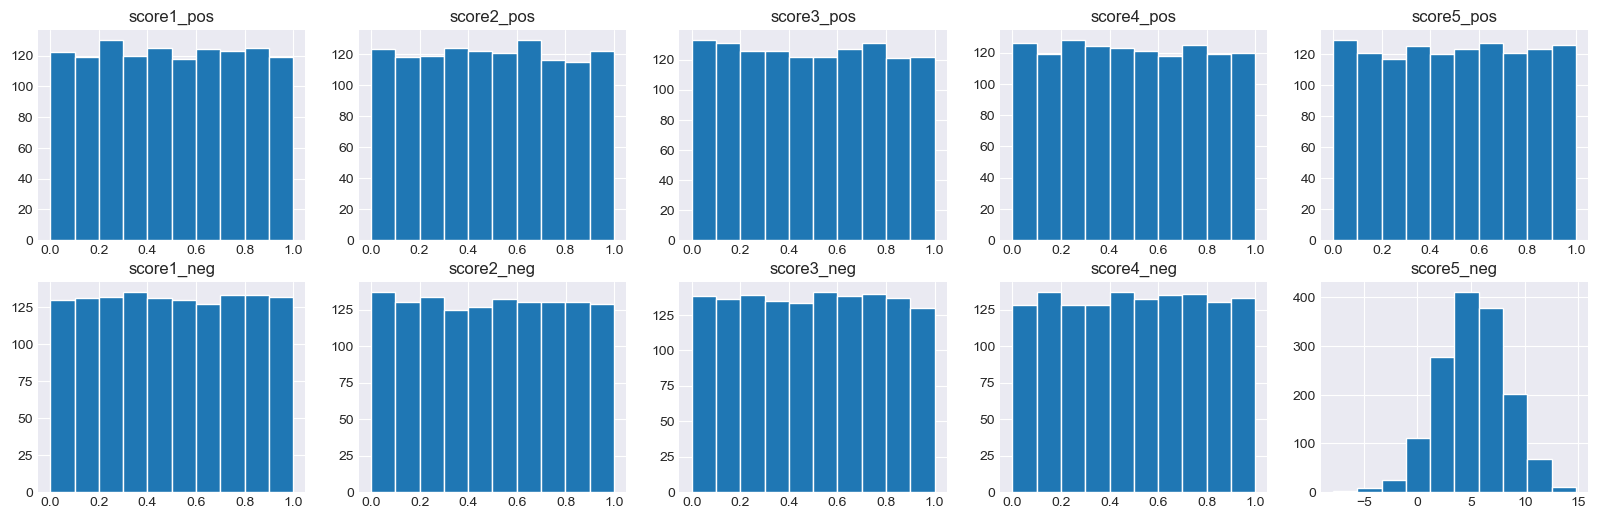

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

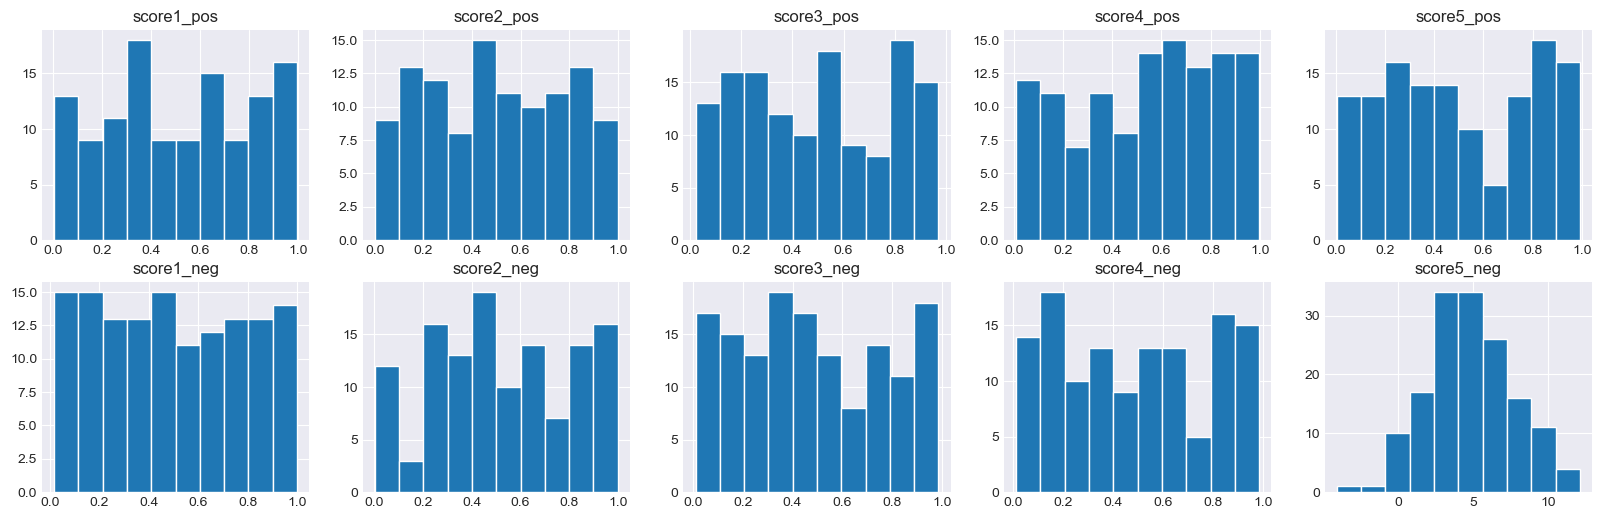

In [26]:
# histogram score
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

Let's in case of hotel 5 convert this score to a quantile value. To do this, we have to be a bit carefull. An easy way to handle this would be to calculate the percentile rank for the score, e.g. : 

```python
train_V2["score5_neg_uniform"]  = train_V2["score5_neg"].rank(method='max', pct=True)
```

However, it would be rather difficult to apply this consistently on the independent score dataset later on. So, as an alternative we will get the quantiles from the cumulative distribution function, we can do this via the emprical cdf or rescale the distribution to zero mean and unit variance, assuming it's shape to be - let's say - Gaussian and compute the quantiles from that cdf, keeping things simple, we opted to calculate the z-score, assume the distribution is roughly Gaussian(without rigorously checking, as this probably won't affect the result significantly) in the following way, using `scipy.stats.norm.cdf`.

In [27]:
train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])
score["score5_neg_uniform"] = ( score["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
score["score5_neg_uniform"] = stats.norm.cdf(score["score5_neg_uniform"])

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

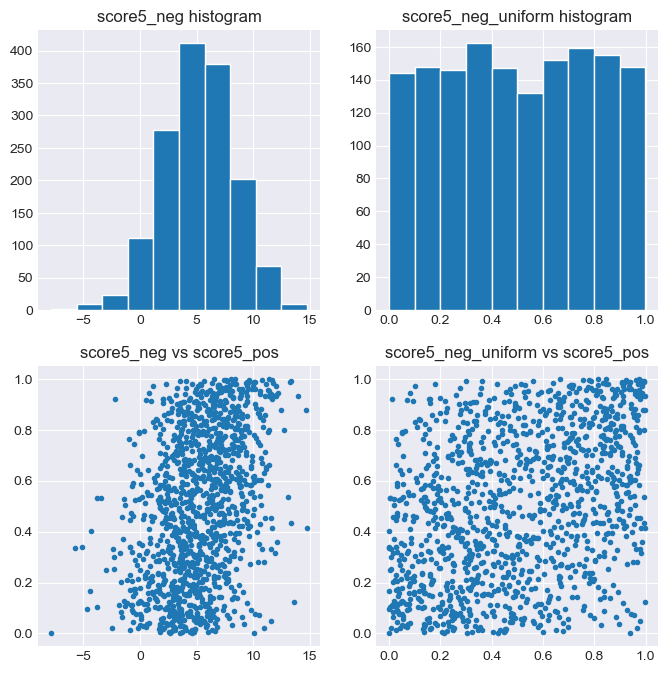

In [28]:
# -- a small check to make sure it worked
fig, axs = plt.subplots(2,2, figsize=(8,8))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

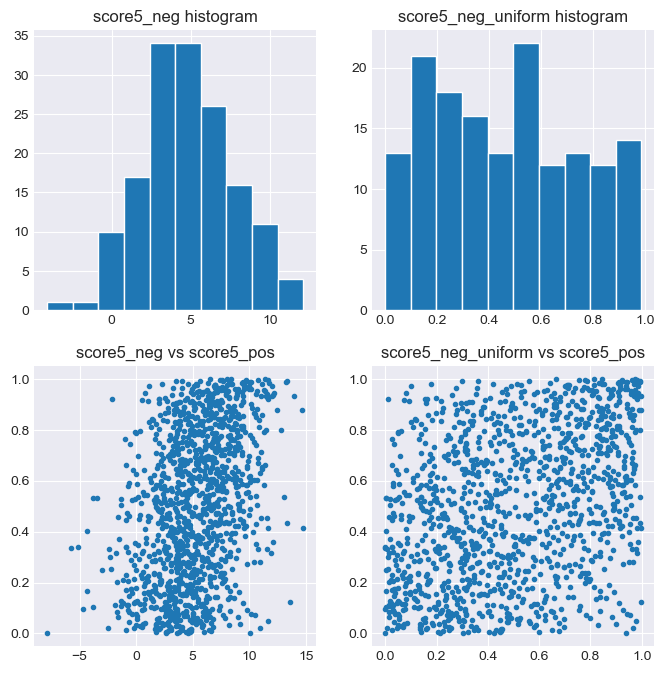

In [29]:
# -- a similar check on score data
fig, axs = plt.subplots(2,2, figsize=(8,8))
score["score5_neg"].hist(ax=axs[0][0])
score["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [30]:
# -- and now replace the variable in the dataset for training data and for score
train_V2['score5_neg'] = train_V2['score5_neg_uniform']
train_V2.drop(columns=['score5_neg_uniform'], inplace=True)
score['score5_neg'] = score['score5_neg_uniform']
score.drop(columns=['score5_neg_uniform'], inplace=True)

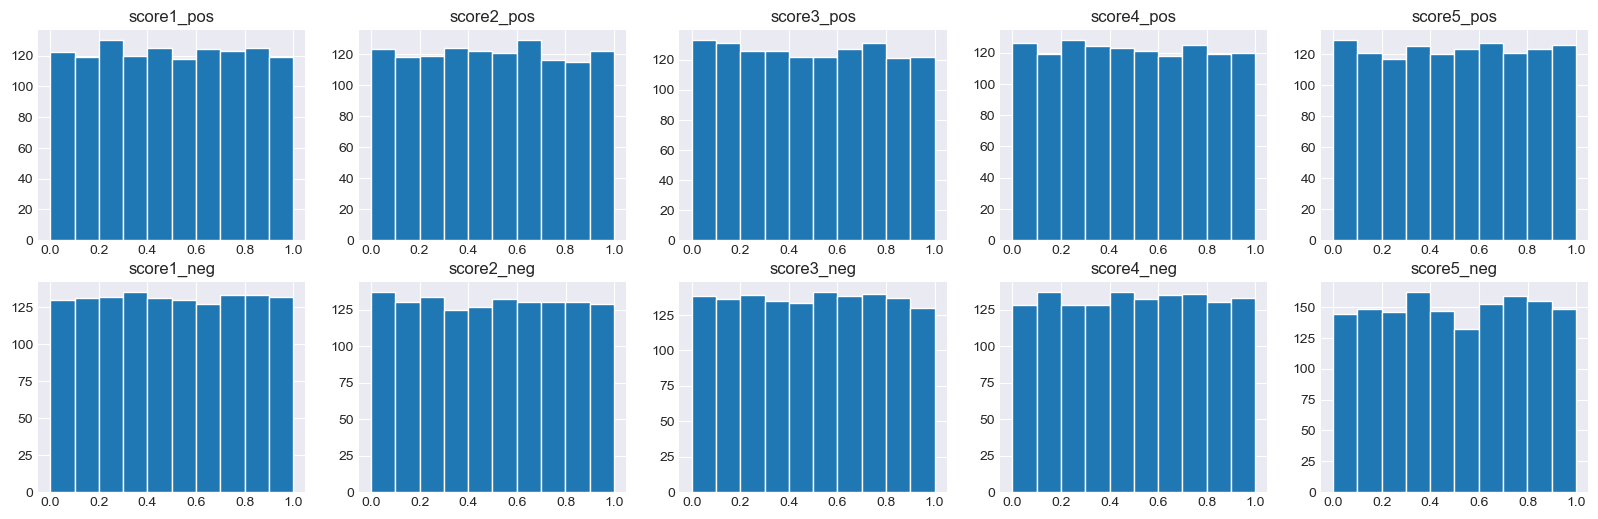

In [31]:
# -- make a small plot to check the results:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

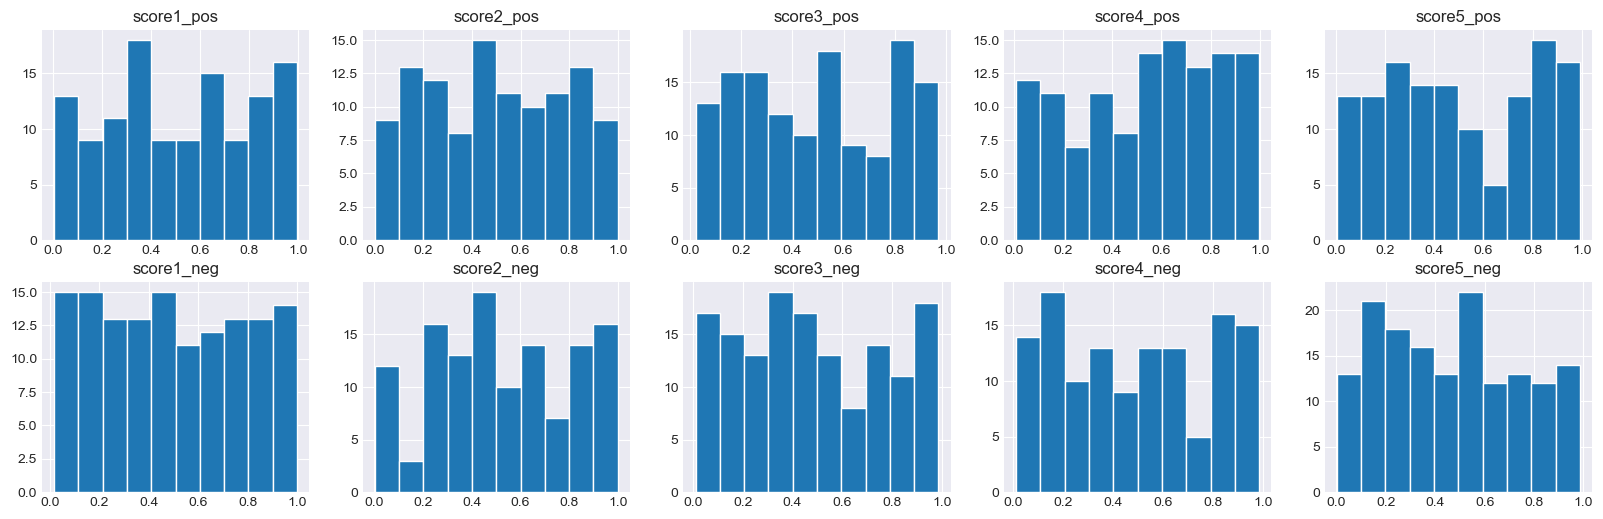

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

### Consistency between damage incurred and damage amount

In [33]:
print(f"Max damage amount when no damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 0, 'outcome_damage_amount'].max()}")
print(f"Min damage amount when damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 1, 'outcome_damage_amount'].min()}")

Max damage amount when no damage is incurred : 0.0
Min damage amount when damage is incurred : 0.0


Ha, so there are cases for which there is damage incurred, but the amount of the damage is 0 ... interesting

## Handling of  missing data

In this section we will in tree steps deal with missing data in the training and score datasets. First we will get an overview of the number of missing values per features. Secondly we will do some special processing for the features containing the scores given by previously visited hotels. Thirdly we will determine what to do with the other features that have missing data.

### General analysis

In [36]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missing values, sorted ascending
print("Top 20 features with the most missing features: ")
total_missings.head(20)  # Show top 20 features with the highest amount of miwwing feaures

Top 20 features with the most missing features: 


score2_pos         3791
score4_pos         3777
score1_pos         3775
score5_pos         3768
score3_pos         3739
score2_neg         3696
score1_neg         3686
score4_neg         3676
score3_neg         3633
score5_neg         3507
tenure_yrs          392
tenure_mts          392
neighbor_income     239
shop_use             88
presidential         88
cab_requests         88
dining_ic            88
company_ic           53
claims_no            53
income_am            53
dtype: int64

Let's put it in graphs.

<Axes: title={'center': 'Number of missing values per feature'}>

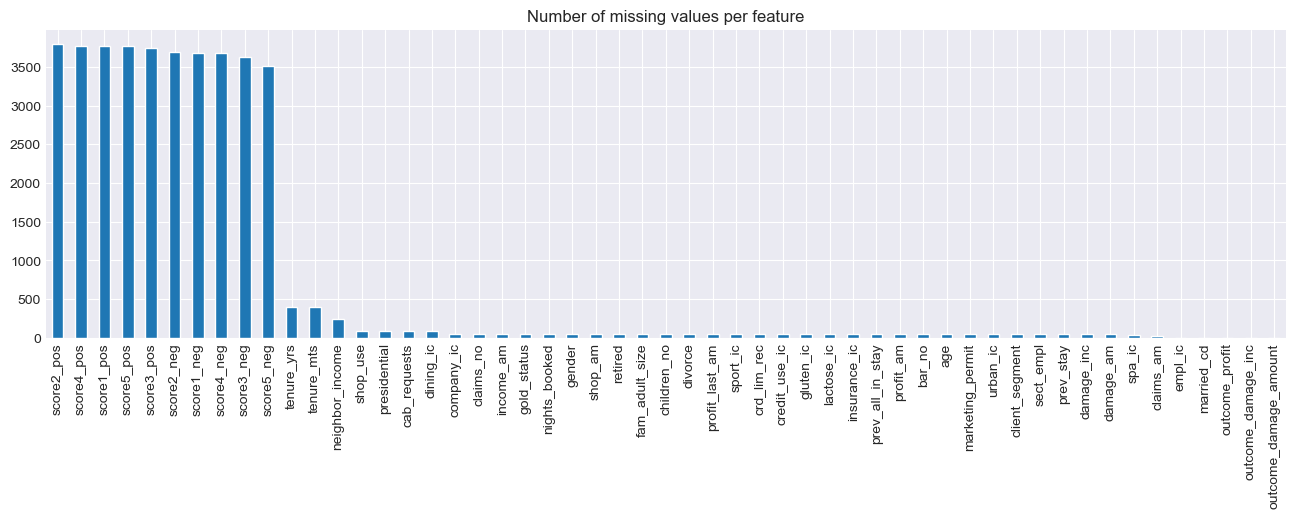

In [38]:
total_missings.plot(kind='bar', figsize=(16,4), title="Number of missing values per feature")

In [39]:
# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missing values, sorted

We split of the score features to be able to get a better view on the other features who do not have that many mising values.

<Axes: ylabel='pct. missing [%]'>

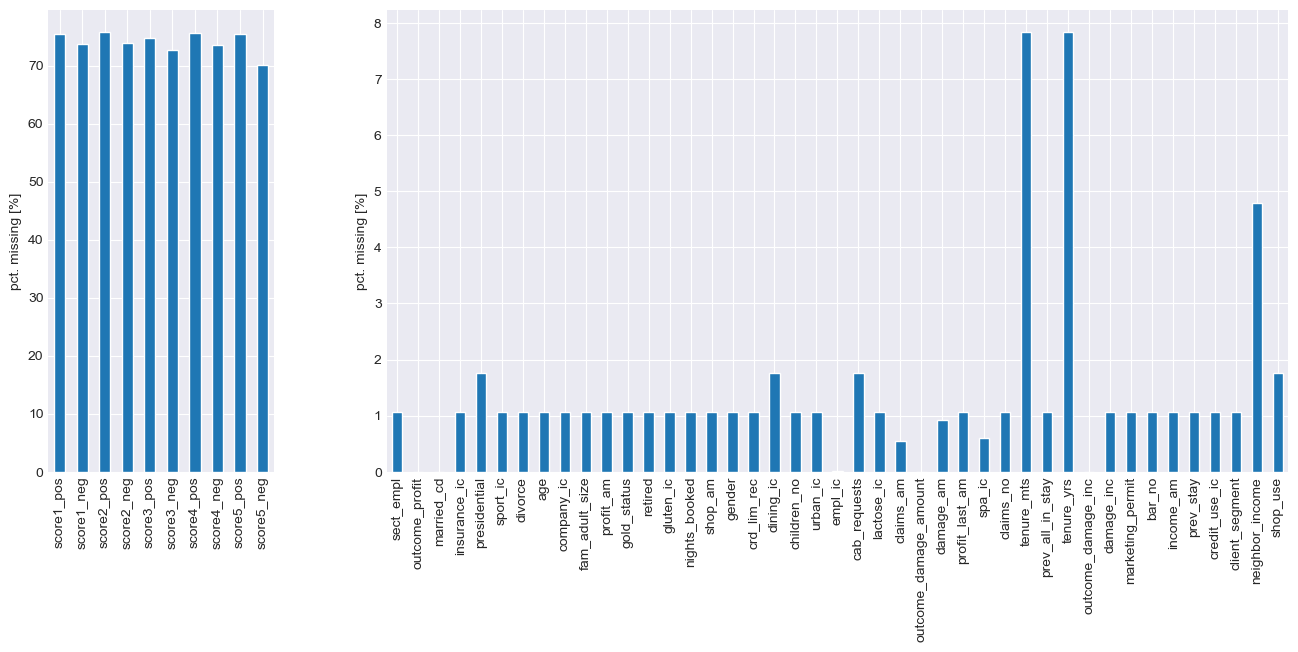

In [40]:
score_vars = [ f"score{i+1}_{xx}" for i in range(5) for xx in ("pos", "neg") ]
other_vars = list(set(train_V2.columns).difference(score_vars))

fig, axs = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})

axs[0].set_ylabel('pct. missing [%]')
axs[1].set_ylabel('pct. missing [%]')

pct_missings[score_vars].multiply(100.).plot(kind='bar', ax=axs[0])
pct_missings[other_vars].multiply(100.).plot(kind='bar', ax=axs[1])

Some conclusions :
- no missing values in the outcomes
- a lot of missing values in the scores given by the hotels (> 70% of the data), however despite the large quantity of missing data, it doesn't seem a good idea to throw away this data as the score given by other hotels in the chain may be a very relevant predictor, so we decide to keep these features and create a specific solution for the missing values (which in its own right may be relevant information as well). 
- tenure_mts does have almost 10% missing --> perhaps we should not just drop it, but re-use the years to fill in the missings.
- it's striking that a large number of features report the same amount of missing values, so these are probably a set of rows which we should consider dropping.

### Dealing with the missing values in the score features.

The imputation of the score values is somewhat tricky. There is potentially a lot of information encoded in there, but also > 70 % of missing values. First of all we do not know from the dataset what hotels correspond to 1, 2, ... 5 also we do not know from the description that hotel 1 from the training set corresponds to hotel 1 in the score set. By aggregating the scores (.e.g. calculating a mean over the hotels for both the positivity and negativity scores, we can already get rid of a lot of missing values, however the downside is that the information on what hotel did give the score is lost then). Still this may be a good way forward as we don't know for sure whether the hotels in the training & score set correspond (though it's probably safe to assume so). One caveat with this approach is that we would be averaging quantile values, which may not be entirely consistent so it would probably be better to average the original scores, but then we would have to make assumptions on the underlying distribution of these original scores. For a discussion we refer to : https://github.com/Marijkevandesteene/MachineLearning/issues/8

In [41]:
train_V2["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

score["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
score["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

In [42]:
train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].head()

,score1_pos,score2_pos,score3_pos,score4_pos,score5_pos
Id,,,,,
0,0.467768,NaN,NaN,0.838147,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,0.232375,NaN,NaN,0.101955
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.330503,0.490486,NaN


Text(0.5, 1.0, 'avg_score_pos')

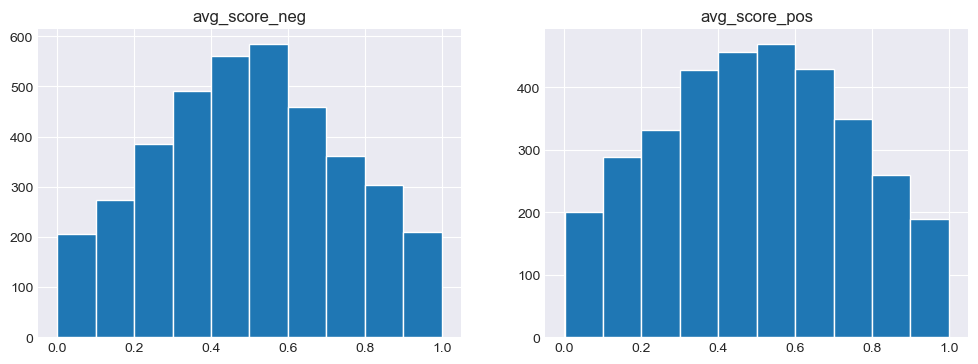

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["avg_score_neg"].hist(ax=axs[0])
train_V2["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

Text(0.5, 1.0, 'avg_score_pos')

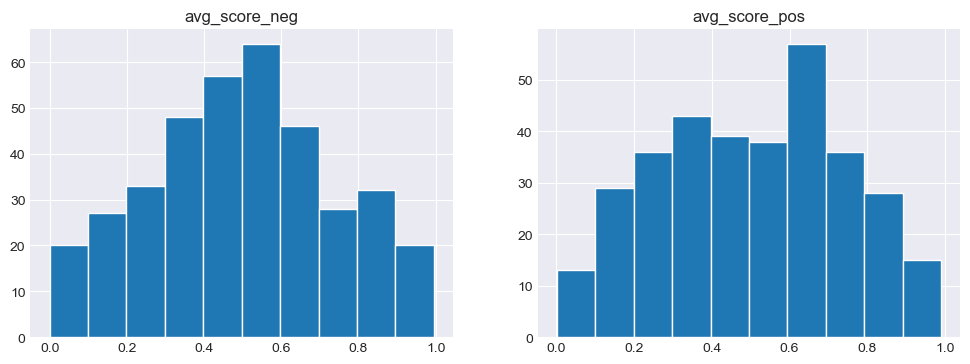

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
score["avg_score_neg"].hist(ax=axs[0])
score["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

In [45]:
# missing percentages when computing the mean
train_V2[["avg_score_pos", "avg_score_neg"]].isnull().mean().sort_values(ascending=False)

avg_score_pos    0.3194
avg_score_neg    0.2332
dtype: float64

We can see that if we compute the mean, we already reduce the number of missings to about 20 - 30 %, which is already an improvement compared to the ~70 % missing values on average per hotel. The fact however that scores for hotel guests are missing may also be a relevant feature, so we decide to include that as an additional feature, but in fact we can also count how many hotels have given the score, so 0 will be no hotels (i.e. missing) and then 1 -> 5 for how many hotels have given the score. That way we include the maximum amount of information from the original scores, only neglecting the actual hotels which have given the score which we don't know anyway which is which from the data given and whether the hotel labels are consistent between training & score set. That way we can think of imputing an average score to keep those records in the dataset, as we know it was originally missing (i.e. num_score_pos/neg == 0)

In [46]:
# -- count the number of hotels which have given a score, so 0 means it was originally missing for all the hotels
train_V2["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
train_V2["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

score["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
score["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

# -- and add it to the categorical variables
#categorical_input_features.extend(["score_pos_missing", "score_neg_missing"])
numerical_input_features = [ ft for ft in numerical_input_features if not ft.startswith("score") ]
numerical_input_features.extend(["avg_score_pos", "avg_score_neg", "num_score_pos", "num_score_neg"])

In [47]:
# -- now drop the original scores from the dataset and from the score dataset
train_V2.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
train_V2.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

score.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
score.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

In [48]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,1791.66,0,0.00,0.652958,0.532814,2,2
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,1672.78,1,829.66,NaN,0.808991,0,1
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,1001.40,0,0.00,0.167165,0.118495,2,2
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,1785.59,0,0.00,NaN,0.889793,0,1
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,3140.74,0,0.00,0.410495,0.654370,2,2


### Dealing with the missing values in the tenure_yrs feature

In the analysis above we also noticed a significant amount of missing values for `tenure_yrs` and `tenure_mts`. What is also striking is that probably both variables express the same quantity, one expressed in months and one in years. Let's visualise that in a scatter plot : 

In [49]:
train_V2[["tenure_mts", "tenure_yrs"]].head()

,tenure_mts,tenure_yrs
Id,,
0,476.0,40.0
1,27.0,2.0
2,95.0,8.0
3,NaN,NaN
4,354.0,30.0


Text(0.5, 0, '12 * tenure_yrs')

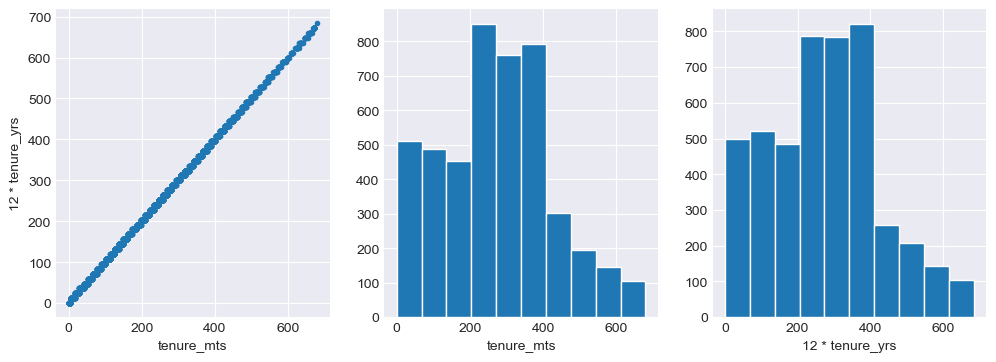

In [50]:
# -- make a scatterplot and two histograms
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].plot(train_V2['tenure_mts'], 12.*train_V2['tenure_yrs'], '.')
axs[0].set_xlabel("tenure_mts")
axs[0].set_ylabel("12 * tenure_yrs")
train_V2["tenure_mts"].hist(ax=axs[1])
axs[1].set_xlabel("tenure_mts")
(12.*train_V2["tenure_yrs"]).hist(ax=axs[2])
axs[2].set_xlabel("12 * tenure_yrs")

First we check if both variables contain the same missings, as imputing missing `tenure_mts` from `tenure_yrs` would be a straighforward choice

In [51]:
# -- get the missing values for both
tenure_num_values = train_V2[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

In [52]:
# -- get the missing values for both in the score dataset
tenure_num_values = score[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

No, so `tenure_mts` `tenure_yrs` either both occur in the dataset, or neither of them. So clearly, both are expressing the same variable, one expressed in years, the other in months and having established that we can't directly use either one to impute missing values in the other feature, it probably makes no sense to include both. Let's therefore omit the one with the lowest granularity : 

In [53]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)
score.drop(columns=['tenure_yrs'], inplace=True)

numerical_input_features.remove("tenure_yrs")

### Dealing with the remaining missings

We still see that for a large amount of features, there are around 53 missings. Likely, these are records which are not complete. We can clearly see this in the histogram below, which plots the number of missing features per record. 

In [54]:
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43


Text(0.5, 0, 'Missing features per record for the score dataset')

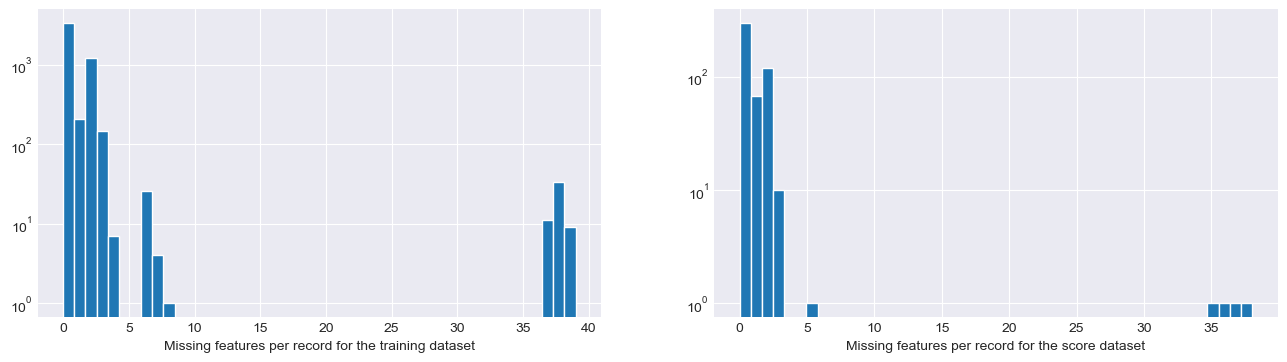

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# -- a histogram of the amount of missing features per record
train_V2.isnull().sum(axis=1).hist(ax=axs[0], bins=46, log=True)
axs[0].set_xlabel("Missing features per record for the training dataset")

# -- a histogram of the amount of missing features per record in the score dataset 
score.isnull().sum(axis=1).hist(ax=axs[1], bins=46, log=True)
axs[1].set_xlabel("Missing features per record for the score dataset")

We clearly see that for the majority of the records, the number of missing features is less than 10, however for a small amount, we have more than 35 missing features. It appears there are 53 such records. This is a minimal loss of data on a total of 5000 records (1.06 %) and we assume that the data collection for some unknown reason went horribly wrong. So we delet those records.

We see a similar pattern in the score dataset. There we have 4 instances. 

We can either work with a cutoff on the number of missing features per record, like so : 

```python
drop_records = train_V2[train_V2.isnull().sum(axis=1) > 35]
print(f"Number of records with > 35 missing features : {drop_records.shape[0]}")
train_V2.drop(index=drop_records.index, inplace=True)
```

or explicitly look at what features are missing, it turns out that : 


In [56]:
train_V2.shape

(5000, 46)

In [134]:
# For a number of instances (53) data seems to be missing for a lot of features (24). These instances may be eliminated from the dataset
instances_missingsData = train_V2[train_V2.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
train_V2 = train_V2.drop(instances_missingsData.index)

(53, 46)


In [135]:
#For a number of instances (4) in score.csv data seems to be missing for a list of features. These will be eliminated from the score set, since comparable instances were removed from the training set
# These are not withheld in the list of clients 
instances_missingsData = score[score.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
score = score.drop(instances_missingsData.index)

(4, 43)


After dropping these instances with more than 35 missing feature, we see that there is data for the following features (other features are NaN):
- `spa_ic` is 23x = 1 (2/21: outcome_damage_ic = 1)
- `empl_ic` is 52x = 0 (12/40: outcome_damage_ic = 1)
- `married_cd` is 53x = false (12/53: outcome_damage_ic = 1)
- `claims_am` is 26x = 0 (6/20: outcome_damage_ic = 1)
- `spa_ic` & `claims_am` & `empl_ic` has data for 6 of these instances 

In [57]:
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

print(f"Shape train_V2 dataset after transformations so far: {train_V2.shape}")
print(f"Shape score dataset after transformations so far: {score.shape}")


Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43
Shape train_V2 dataset after transformations so far: (5000, 46)
Shape score dataset after transformations so far: (500, 43)


The only aspect of dealing with the missing data remaining is to impute the missing data not yet dealt with..

In [58]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


avg_score_pos       1597
avg_score_neg       1166
tenure_mts           392
neighbor_income      239
presidential          88
dining_ic             88
shop_use              88
cab_requests          88
prev_stay             53
prev_all_in_stay      53
divorce               53
fam_adult_size        53
children_no           53
income_am             53
profit_last_am        53
claims_no             53
nights_booked         53
gender                53
shop_am               53
retired               53
gold_status           53
company_ic            53
sect_empl             53
client_segment        53
insurance_ic          53
profit_am             53
damage_inc            53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
urban_ic              53
lactose_ic            53
bar_no                53
sport_ic              53
age                   53
marketing_permit      53
damage_am             46
spa_ic                30
claims_am             27
empl_ic                1


Splitting up the features which still have missing data in categorical and continuous.

In [59]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'neighbor_income', 'cab_requests', 'avg_score_pos', 'avg_score_neg']

In [60]:
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False) 
print("These are the rows which contain missing features : ")
row_idx_missing = missing_features[missing_features>0]
print(row_idx_missing)

These are the rows which contain missing features : 
Id
3377    39
2672    39
2348    39
1744    39
4641    39
4545    39
996     39
3068    39
306     39
790     38
2096    38
4000    38
1261    38
517     38
1448    38
4392    38
1696    38
4851    38
4138    38
2696    38
3793    38
3959    38
90      38
1852    38
4946    38
4242    38
3952    38
4477    38
1062    38
3990    38
3213    38
4614    38
1275    38
670     38
2250    38
2058    38
4159    38
4993    38
2917    38
2734    38
4789    38
474     38
1281    37
4669    37
4009    37
2956    37
3198    37
3926    37
4528    37
3326    37
3494    37
1338    37
1164    37
2504     8
7        7
2895     7
863      7
4286     7
1267     6
3166     6
3170     6
1557     6
3015     6
2387     6
3167     6
3142     6
781      6
627      6
1566     6
4642     6
3149     6
3564     6
1782     6
4548     6
3606     6
4940     6
3727     6
1514     6
3192     6
3845     6
3474     6
1021     6
4644     6
3330     6
2618     4
3510     

Instead of separating between numerical and categorical values, we will use a **KNNImputer** to make optimal use of possible correlations between the features. **However**, as the KNN technique is sensitive to the scale of the features (it uses a distance based metric), we first have to rescale the features before being able to use a KNNImputer. Most of our features are categorical between 0 and 1, so we'll just use a MinMaxScaler between 0 and 1 to rescale to that fixed range.

In [61]:
# -- first define the min max scaler and apply to the original data
imputer_scaler = MinMaxScaler().set_output(transform="pandas")

# -- set the target features aside as we will apply the imputer to the score as well, which lacks the target features,
#    so we only use the input feature for transformation & imputing
train_V2_outcome = train_V2[target_features]
train_V2_scaled = imputer_scaler.fit_transform(train_V2.drop(columns=target_features))
score_scaled = imputer_scaler.transform(score)

# -- next define the imputer having 5 neighbours (default) and uniform weights
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform').set_output(transform="pandas")

# -- apply to the scaled data
train_V2_scaled = imputer_knn.fit_transform(X=train_V2_scaled)
score_scaled = imputer_knn.transform(score)

# -- and apply the inverse transform to remove the transformation applied by the scaler
train_V2_inv_transformed = imputer_scaler.inverse_transform(train_V2_scaled)
score_inv_transformed = imputer_scaler.inverse_transform(score_scaled) 

# -- interestingly, the set_output(transform="pandas") is not implemented yet on the inverse transform in sklearn,
#    so we will pour the numpy array into a dataframe ourselves (see:  https://github.com/scikit-learn/scikit-learn/issues/27843) 
#    here we put back the outcome variables which we set aside before we fitted the scaler transform
train_V2 = pd.concat( [ pd.DataFrame(train_V2_inv_transformed, columns=train_V2_scaled.columns).set_index(train_V2_scaled.index), train_V2_outcome ], axis=1 )
score = pd.DataFrame(score_inv_transformed, columns=score_scaled.columns).set_index(score_scaled.index)

We check whether the imputation and scaling and rescaling did not add 'new' categories to the categorical features.

In [62]:
# We print the unique values of the categorical features that needed records to be imputed.

for feat_name in missing_feats_categorical:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2.loc[row_idx_missing.index, feat_name].unique())

Unique values in presidential replaced missing
[0. 1.]
Unique values in dining_ic replaced missing
[0.2 0.  1. ]
Unique values in shop_use replaced missing
[0.  0.2 0.4 1. ]


Ha! so we have a few little bastard slipping through, let's correct !

In [63]:
train_V2.loc[train_V2['dining_ic'] < 0.5,'dining_ic'] = 0.
train_V2.loc[train_V2['dining_ic'] >= 0.5,'dining_ic'] = 1.
train_V2.loc[train_V2['shop_use'] < 0.5,'shop_use'] = 0.
train_V2.loc[train_V2['shop_use'] >= 0.5,'shop_use'] = 1.

score.loc[score['dining_ic'] < 0.5,'dining_ic'] = 0.
score.loc[score['dining_ic'] >= 0.5,'dining_ic'] = 1.
score.loc[score['shop_use'] < 0.5,'shop_use'] = 0.
score.loc[score['shop_use'] >= 0.5,'shop_use'] = 1.

Let's know also check for the other categorical features.

In [119]:
for feat_name in categorical_input_features:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2[feat_name].unique())

Unique values in client_segment replaced missing
[1. 2. 3. 0. 4.]
Unique values in sect_empl replaced missing
[1. 0. 4. 6. 2. 3.]
Unique values in credit_use_ic replaced missing
[0. 1.]
Unique values in gluten_ic replaced missing
[0. 1.]
Unique values in lactose_ic replaced missing
[0. 1.]
Unique values in insurance_ic replaced missing
[0. 1.]
Unique values in spa_ic replaced missing
[1. 0.]
Unique values in empl_ic replaced missing
[0. 1.]
Unique values in married_cd replaced missing
[1. 0.]
Unique values in sport_ic replaced missing
[1. 0.]
Unique values in marketing_permit replaced missing
[0. 1.]
Unique values in urban_ic replaced missing
[1. 0.]
Unique values in dining_ic replaced missing
[0. 1.]
Unique values in presidential replaced missing
[0. 1.]
Unique values in prev_stay replaced missing
[1. 0.]
Unique values in prev_all_in_stay replaced missing
[1. 0.]
Unique values in divorce replaced missing
[0. 1.]
Unique values in company_ic replaced missing
[0. 1.]
Unique values in gen

Clearly the scaler is the issue not the imputer, so another round of correcting.

In [117]:
train_V2.loc[train_V2['client_segment'] < 0.5,'client_segment'] = 0.
train_V2.loc[(train_V2['client_segment'] < 1.5) & (train_V2['client_segment'] >= 0.5) & (train_V2['client_segment'] != 1),'client_segment'] = 1.
train_V2.loc[(train_V2['client_segment'] < 2.5) & (train_V2['client_segment'] >= 1.5) & (train_V2['client_segment'] != 2),'client_segment'] = 2.
train_V2.loc[(train_V2['client_segment'] < 3.5) & (train_V2['client_segment'] >= 2.5) & (train_V2['client_segment'] != 3),'client_segment'] = 3.
train_V2.loc[(train_V2['client_segment'] < 4.5) & (train_V2['client_segment'] >= 3.5) & (train_V2['client_segment'] != 4),'client_segment'] = 4.
train_V2.loc[train_V2['client_segment'] >= 4.5,'client_segment'] = 1.
train_V2.loc[train_V2['sect_empl'] < 0.5,'sect_empl'] = 0.
train_V2.loc[(train_V2['sect_empl'] < 1.5) & (train_V2['sect_empl'] >= 0.5) & (train_V2['sect_empl'] == 1),'sect_empl'] = 1.
train_V2.loc[(train_V2['sect_empl'] < 2.5) & (train_V2['sect_empl'] >= 1.5) & (train_V2['sect_empl'] == 2),'sect_empl'] = 2.
train_V2.loc[(train_V2['sect_empl'] < 3.5) & (train_V2['sect_empl'] >= 2.5) & (train_V2['sect_empl'] == 3),'sect_empl'] = 3.
train_V2.loc[(train_V2['sect_empl'] < 4.5) & (train_V2['sect_empl'] >= 3.5) & (train_V2['sect_empl'] == 4),'sect_empl'] = 4.
train_V2.loc[(train_V2['sect_empl'] < 5.5) & (train_V2['sect_empl'] >= 4.5) & (train_V2['sect_empl'] == 5),'sect_empl'] = 5. #Assuming that a fifth category exists
train_V2.loc[train_V2['sect_empl'] >= 5.5,'sect_empl'] = 6.

score.loc[score['client_segment'] < 0.5,'client_segment'] = 0.
score.loc[(score['client_segment'] < 1.5) & (score['client_segment'] >= 0.5) & (score['client_segment'] != 1),'client_segment'] = 1.
score.loc[(score['client_segment'] < 2.5) & (score['client_segment'] >= 1.5) & (score['client_segment'] != 2),'client_segment'] = 2.
score.loc[(score['client_segment'] < 3.5) & (score['client_segment'] >= 2.5) & (score['client_segment'] != 3),'client_segment'] = 3.
score.loc[(score['client_segment'] < 4.5) & (score['client_segment'] >= 3.5) & (score['client_segment'] != 4),'client_segment'] = 4.
score.loc[score['client_segment'] >= 4.5,'client_segment'] = 5.
score.loc[score['sect_empl'] < 0.5,'sect_empl'] = 0.
score.loc[(score['sect_empl'] < 1.5) & (score['sect_empl'] >= 0.5) & (score['sect_empl'] == 1),'sect_empl'] = 1.
score.loc[(score['sect_empl'] < 2.5) & (score['sect_empl'] >= 1.5) & (score['sect_empl'] == 2),'sect_empl'] = 2.
score.loc[(score['sect_empl'] < 3.5) & (score['sect_empl'] >= 2.5) & (score['sect_empl'] == 3),'sect_empl'] = 3.
score.loc[(score['sect_empl'] < 4.5) & (score['sect_empl'] >= 3.5) & (score['sect_empl'] == 4),'sect_empl'] = 4.
score.loc[(score['sect_empl'] < 5.5) & (score['sect_empl'] >= 4.5) & (score['sect_empl'] == 5),'sect_empl'] = 5. #Assuming that a fifth category exists
score.loc[score['sect_empl'] >= 5.5,'sect_empl'] = 6.

In [118]:
for feat_name in categorical_input_features:
    if feat_name == 'client_segment' or feat_name == 'sect_empl':
        continue
    else:
        train_V2.loc[train_V2[feat_name] < 0.5,feat_name] = 0.
        train_V2.loc[train_V2[feat_name] >= 0.5,feat_name] = 1.
        
        score.loc[score[feat_name] < 0.5,feat_name] = 0.
        score.loc[score[feat_name] >= 0.5,feat_name] = 1.

Now finally test whether we still have missing values

In [64]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {train_V2.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


## Anomaly and outlier detection

Now, before moving onwards, we still want to have a look to possible outliers in the data in order to decide what to do with them. Let's start with some simple visualisations like boxplots and histograms to get a feeling for the distribution of the features. 

### Univariate analysis

We first make some boxplots and histograms for every feature.

In [65]:
# -- for the plots
nrows = 6
ncols = 8

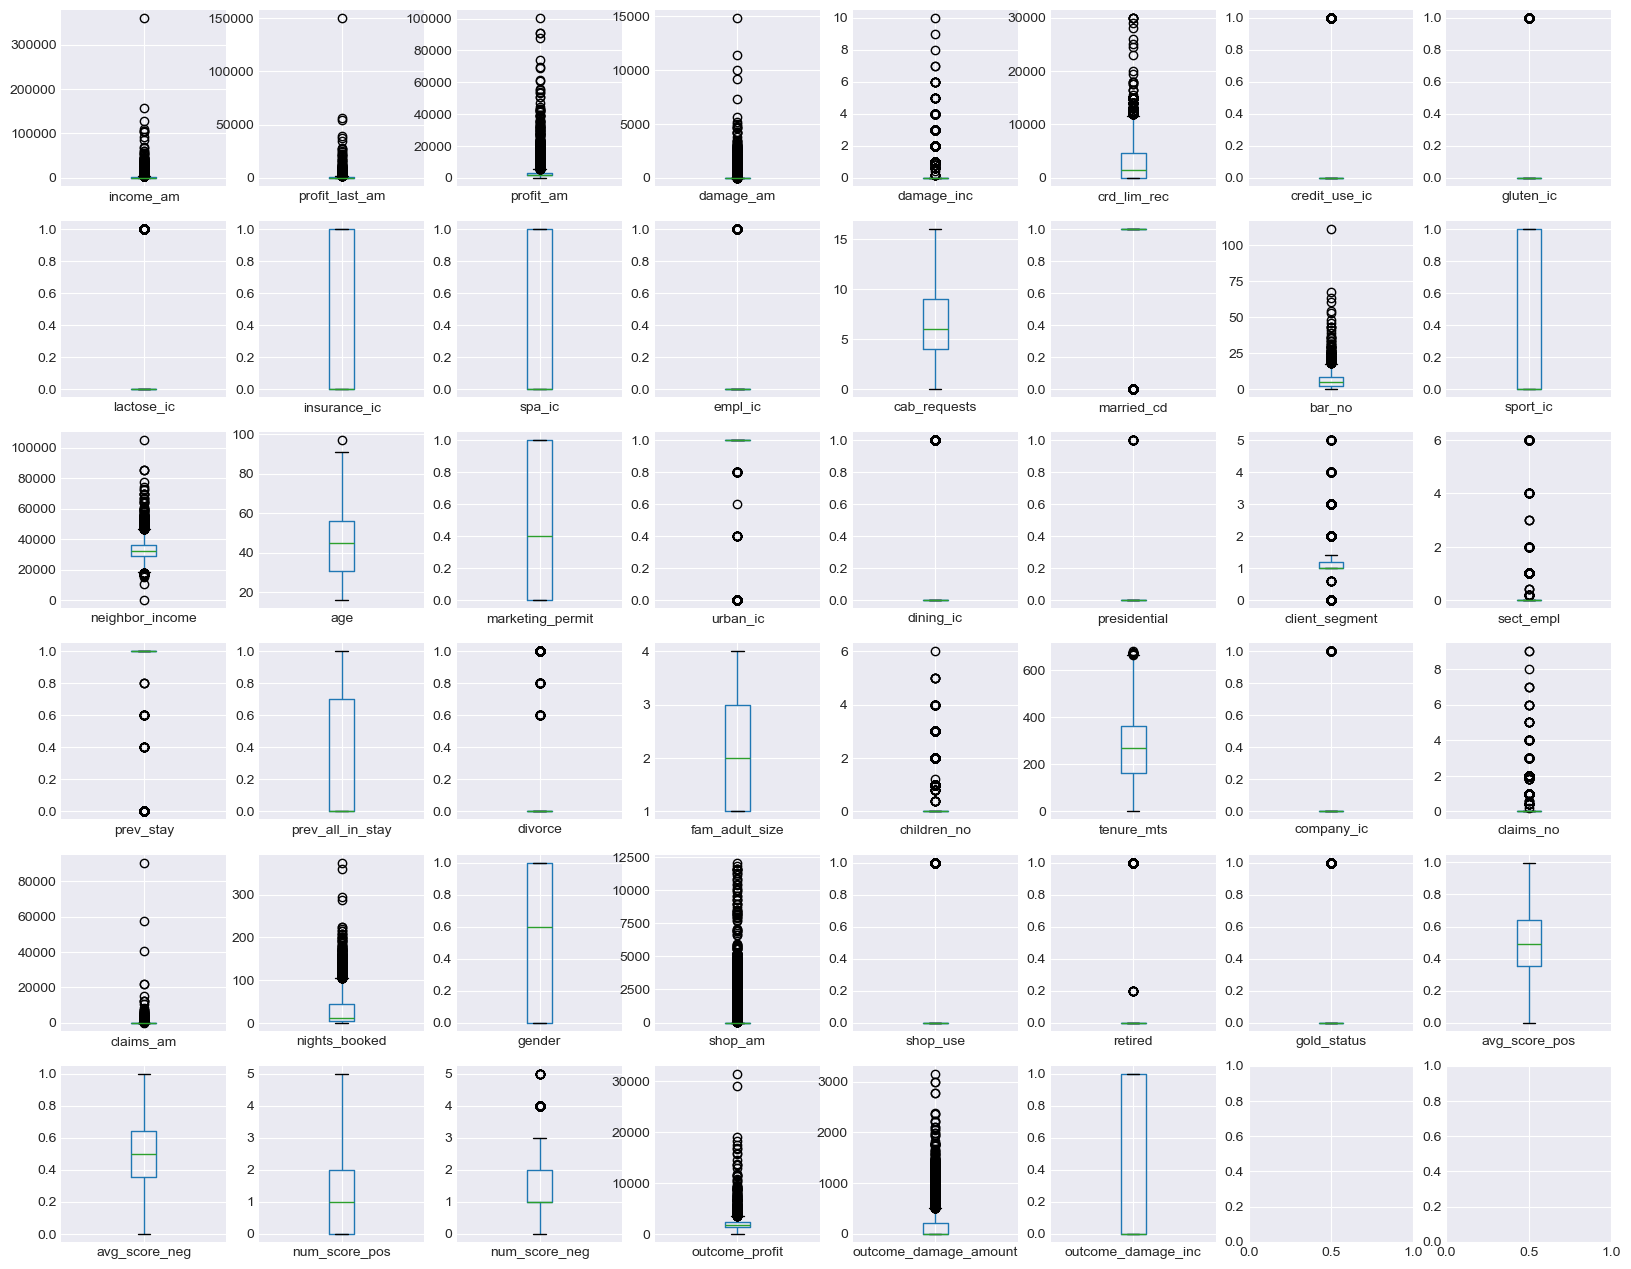

In [66]:
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.boxplot([feat_name], ax=axs[row][col])

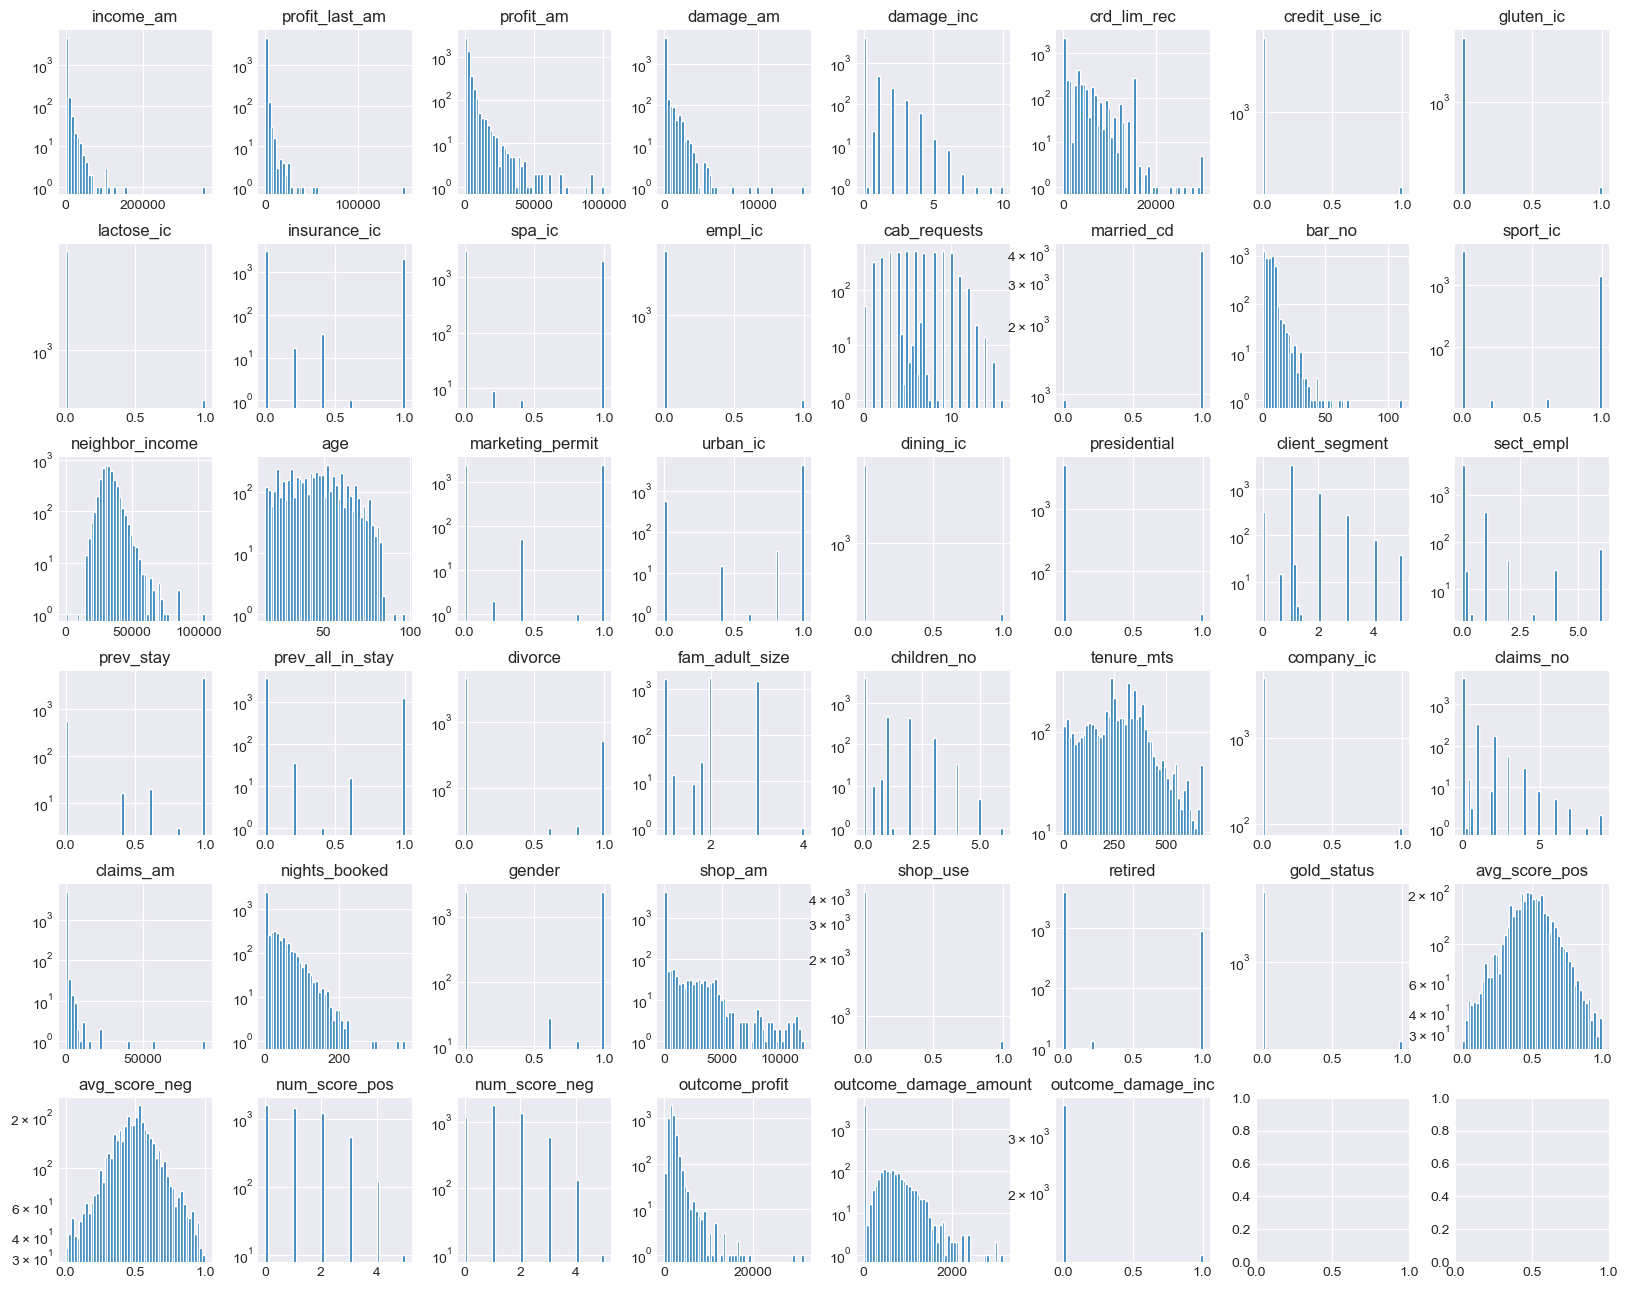

In [67]:
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.hist(feat_name, bins=50, ax=axs[row][col], log=True)

We can already make a couple of interesting observations : 
- There (visually) seem so be some outliers present in the distributions for `income_am`, `profit_last_am`, `damage_am`, `bar_no`, `claims_am`, and `outcome_profit`
- There seem to be some records which show a total number of nights booked (`nights_booked`) at the chain of 0 ! This is rather surprising given that these

Let's look at a few of these outliers : 

In [68]:
train_V2[train_V2['outcome_profit'] > 25000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1979,25327.0,15078.0,30156.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,2.0,0.0,50633.0,41.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,2.0,353.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.399627,0.486164,0.0,0.0,31529.0,0.0,0
3763,360577.0,150537.0,61264.0,4771.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,8.0,1.0,48846.0,46.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,26.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.332470,0.504499,2.0,2.0,29046.4,1288.2,1


In [69]:
train_V2.drop(1979, inplace=True)
train_V2.drop(3763, inplace=True)

In [70]:
train_V2[train_V2['income_am'] > 150000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
709,157697.0,8.0,31325.0,0.0,0.0,8000.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,14.0,0.0,33188.4,45.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,242.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.378836,0.26206,3.0,3.0,11451.15,0.0,0


In [71]:
train_V2[train_V2['damage_am'] > 6000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2112,5247.0,1492.0,12741.0,9136.0,7.0,28000.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,3.0,0.0,34823.0,46.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,1.0,575.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.026500,0.703839,1.0,1.0,2775.97,1416.26,1
2253,227.0,0.0,1620.0,11394.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,0.0,22561.0,52.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,358.0,0.0,0.0,0.0,224.0,1.0,0.0,0.0,0.0,0.0,0.326955,0.416902,0.0,0.0,2080.49,733.00,1
2718,227.0,0.0,4808.0,7321.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,1.0,28983.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,238.0,0.0,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.623210,0.522044,0.0,0.0,1353.37,0.00,0
3931,4647.0,1725.0,13871.0,10025.0,9.0,14000.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,1.0,10.0,0.0,51673.0,35.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,1.0,0.0,3.0,2.0,308.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.312075,0.820847,3.0,3.0,9125.84,1538.22,1
4768,53682.0,61.0,29712.0,14866.0,3.0,30000.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,5.0,0.0,34334.0,36.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,359.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.257344,0.746133,1.0,1.0,2071.03,1046.63,1


In [72]:
train_V2[train_V2['bar_no'] > 100 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2512,2341.0,0.0,4922.0,0.0,0.0,3000.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,111.0,0.0,39147.0,51.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,26.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.569805,0.473527,0.0,0.0,1970.7,452.61,1


In [73]:
train_V2[train_V2['claims_am'] > 30000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
818,16991.0,0.0,27679.0,0.0,0.0,12000.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,1.0,16.0,0.0,26044.0,59.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,122.0,0.0,1.0,90587.0,83.0,0.0,0.0,0.0,1.0,0.0,0.456201,0.440444,0.0,0.0,1726.72,829.63,1
2530,227.0,0.0,1620.0,0.0,0.0,11000.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,1.0,2.0,1.0,29817.0,43.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,216.0,0.0,2.0,57222.0,102.0,1.0,0.0,0.0,0.0,0.0,0.641449,0.951726,1.0,1.0,1312.66,0.00,0
4550,286.0,0.0,2959.0,628.0,3.0,2500.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,1.0,34841.0,39.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,324.0,0.0,1.0,40265.0,51.0,0.0,0.0,0.0,0.0,0.0,0.821716,0.902322,2.0,2.0,1587.44,0.00,0


So there seems to be a fairly rich person in the dataset with very high income (>200000), but also high `profit_last_am`, which seems to be in client segment 5  (a higher segment seems correlated with income (not shown)). We don't think this should necessarily be considered as an outlier. 

### Multivariate analysis

In addition to the univariate analysis above, we also looked at an unsupervised technique for outlier detection, namely **isolation forests**

The output of an Isolation Forest model typically includes the anomaly score for each data point. The anomaly score is a measure of how different or isolated a data point is compared to the rest of the data.

In [74]:
# Fitting default isolation forest for anomaly/outlier detection
from sklearn.ensemble import IsolationForest

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
X_train_V2 = train_V2.drop(columns=['outcome_profit','outcome_damage_inc','outcome_damage_amount'], inplace=False)
X_alldata = pd.concat([X_train_V2,score])

if_model.fit(X=X_train_V2)

# Predicting on the same data
y_pred_train = if_model.predict(X=X_train_V2)

# Checking frequency table of predicted values
print('Frequency table of predicted values:')
pd.Series(y_pred_train).value_counts(normalize=True)

Frequency table of predicted values:


 1    0.893557
-1    0.106443
Name: proportion, dtype: float64

According to the isolationForest more than 10% of the data is an outlier. We believe that this percentage is to high looking at the data.
Therefore, we believe that this confirms the conclusion from the univariate analysis.

# OneHotEncoding categorical features

Most of the categorical features are expressed as a boolean but there are two non-boolean categorical features, 'client_segment' and 'sect_empl'. Because some models, particular linear models are at risk of reading thowe wrong so to be on the safe side we will OneHotEncode them using the Sklearn OneHotEncoder.

In [120]:
onehot = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

In [121]:
onehot.fit(train_V2[['client_segment', 'sect_empl']])

OneHotEncoder(sparse_output=False)

In [122]:
Onehotencoded = onehot.transform(train_V2[['client_segment', 'sect_empl']])

In [127]:
train_V2 = train_V2.merge(Onehotencoded, left_index=True, right_index=True)

In [131]:
train_V2 = train_V2.drop(['client_segment', 'sect_empl'], axis = 1)

# Visualisations and exploratory analysis

Now that we have reasonably clean data, let's perform some initial exploratory analysis, correlation plots, etc...

First we will look at whether there is an imbalance in the categorical data.

In [76]:
p = len(train_V2[train_V2['outcome_damage_inc'] == 1])/len(train_V2) * 100
print('The percentage of hotel guests causing damage is {:.2f}'.format(p))      

The percentage of hotel guests causing damage is 25.53


While a 25% split between classes may not be considered highly imbalanced, it could still lead to potential challenges, especially if the classes are not well-represented. It's important to assess the impact of this class distribution on the specific feature that we predict and consider techniques like oversampling, undersampling, or using different evaluation metrics to address any imbalance issues.

We follow this up with a correlation matrix.

<Axes: >

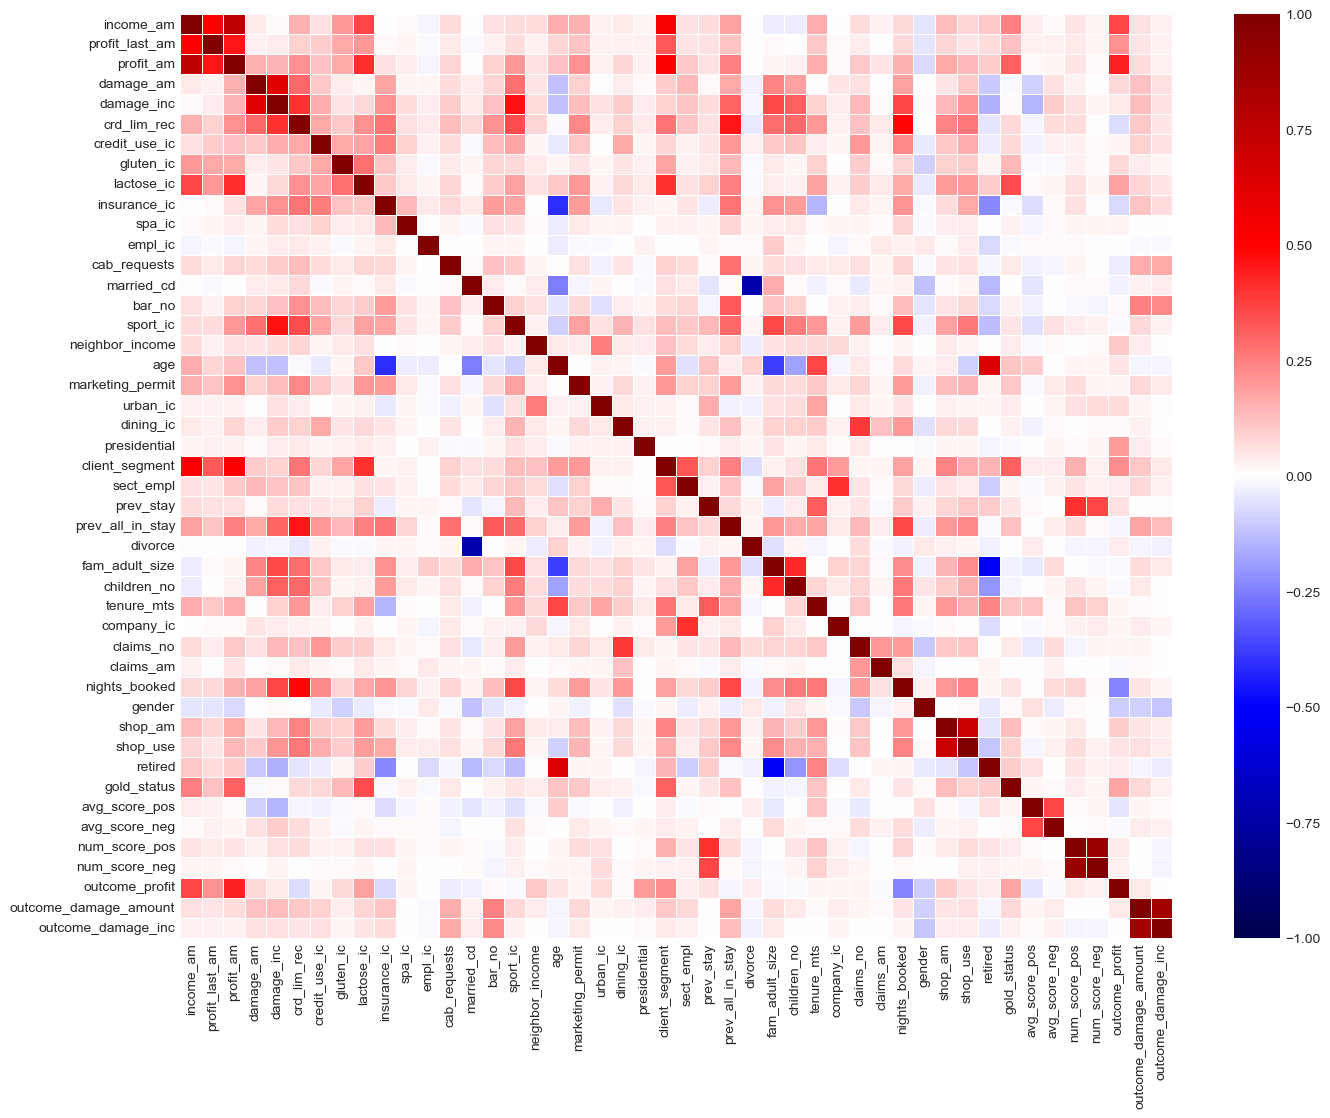

In [77]:
corrmat = train_V2.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corrmat, vmin=-1, vmax=1, center=0, cmap="seismic",  linewidth=.5)

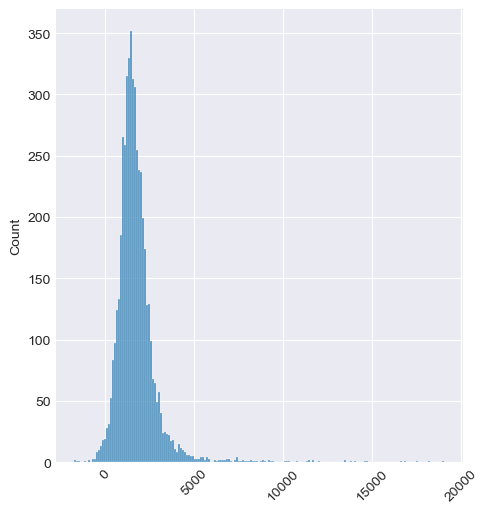

In [78]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['outcome_profit'] - train_V2['outcome_damage_amount']); 
plt.xticks(rotation=45);

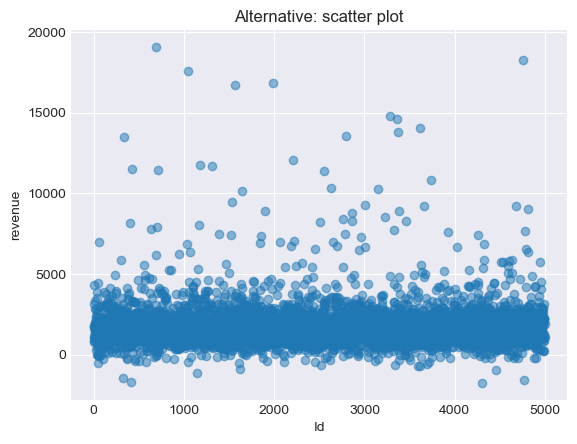

In [79]:
plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['outcome_profit'] - train_V2['outcome_damage_amount'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

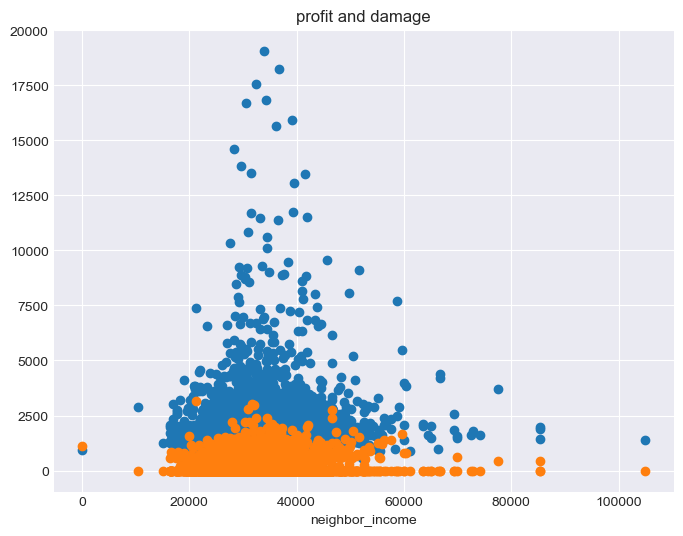

In [80]:
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

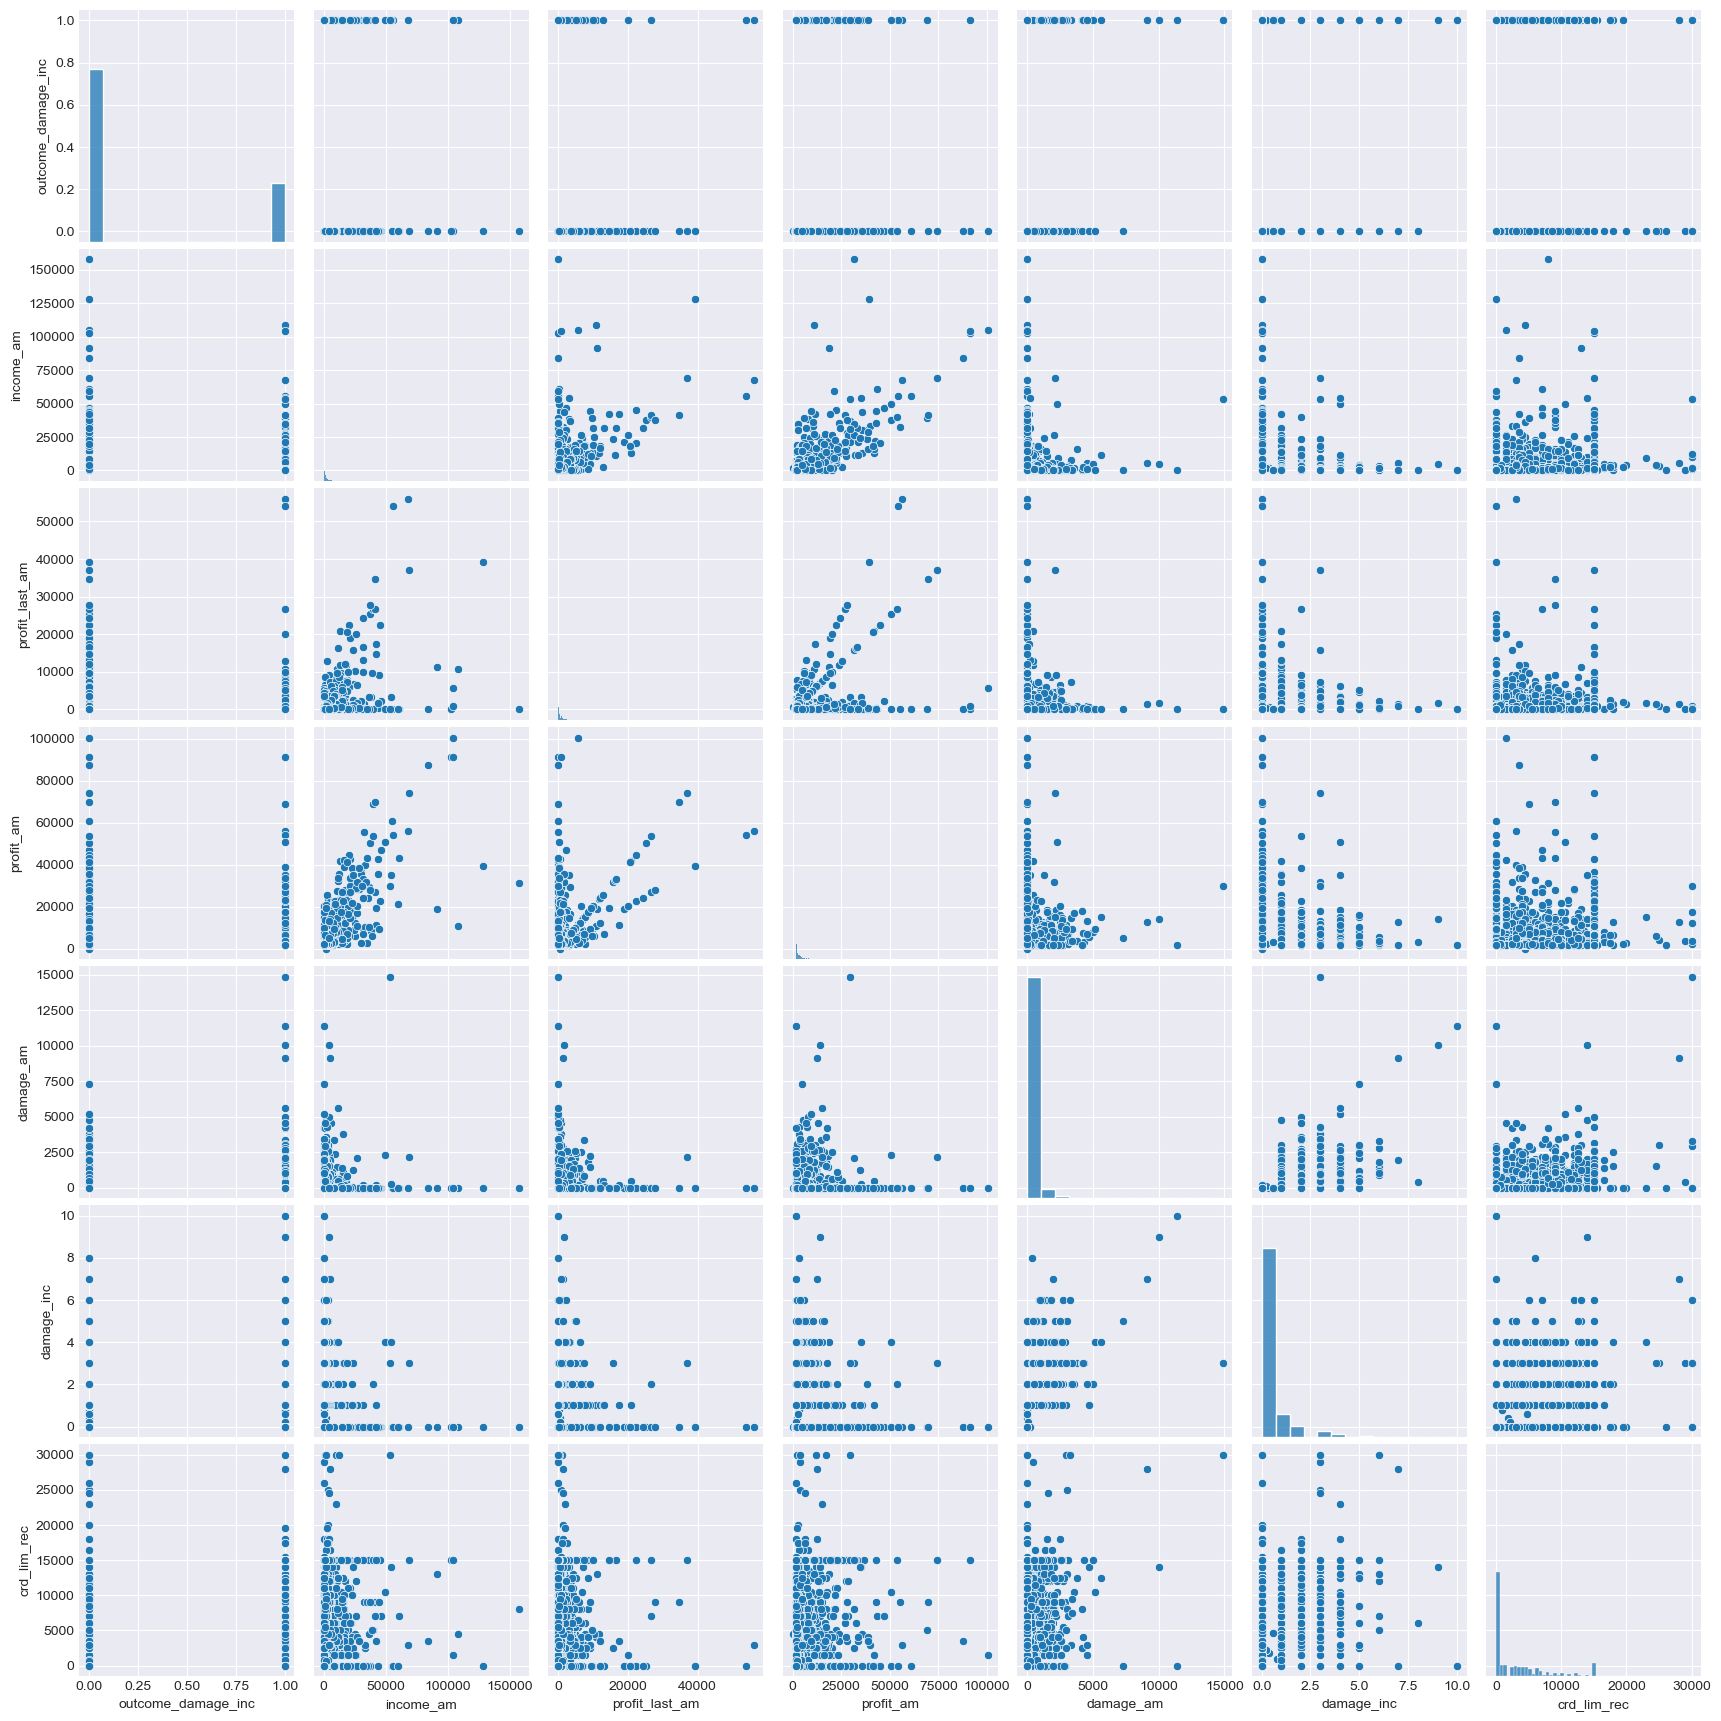

In [81]:
# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

# Model training

For the model training, we each have tried and experimented with a different technique before consolidating the results back together for the final prediction. One important consideration is that the goal of the prediction is in fact for the total revenue, being profit - damage, available as `outcome_profit - outome_damage_amount: 

1. the profit for each client
    - outcome_profit
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage for those who will cause damage / wreak havoc
    - outcome_damage_amount

So different strategies are possible, train a model on profit and damage separately and subtract the model predictions, or directly train on the revenue. We will discuss this in due time as this will depend on the quality of the trained models. Also for the classification problem we will see that different strategies in terms of optimisation are reasonable. Let's dive into it. First we start by making the outcome revenue also available in the dataframe

In [82]:
# -- first we make the revenu per client avaible in the dataframe
train_V2['outcome_revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']
 
# -- be carefull also to include it in the target_features as we want to avoid using it for training
target_features.append('outcome_revenue')

In [83]:
# -- furthermore, save the prepared dataset to disk...
train_V2.to_csv(os.path.join( "output", "train_v2_prep_without_outliers.csv") )
score.to_csv(os.path.join( "output", "score_prep_without_outliers.csv") )

## Some configuration

In [205]:
# -- if the model scans exist on disk, they will be loaded, otherwise re-fitted, unless the parameter below is True
overwrite_model_training = False

# -- filenames for the random forest scans 
rf_profit_scan_filename = os.path.join( 'models', 'rf_profit_random_search.pkl')
rf_damage_scan_filename = os.path.join( 'models', 'rf_damage_random_search.pkl')
rf_revenu_scan_filename = os.path.join( 'models', 'rf_revenu_random_search.pkl')

# -- filenames for the gradient booster scans
gbm_profit_scan_filename = os.path.join( 'models', 'gbm_profit_random_search.pkl')
gbm_damage_scan_filename = os.path.join( 'models', 'gbm_damage_random_search.pkl')
gbm_revenu_scan_filename = os.path.join( 'models', 'gbm_revenu_random_search.pkl')

# -- classification
rfc_damage_scan_filename = os.path.join( 'models', 'rfc_damage_random_search.pkl')
gbmc_damage_scan_filename = os.path.join( 'models', 'gbmc_damage_random_search_recall.pkl')

## Model for predicting the outcome_profit

Goal of the What do we need to predict? 
1. the revenue per client (= profit - damage)

We could fit the revenue by fitting the profit and by fitting the damage and subtracting them. Or we could calculate the revenue in the training set and fit the revenue as such.

When you need to predict a difference, you would typically predict each term individually and then calculate the difference between the predicted values. By predicting each term separately, you can estimate the values of the components involved in the difference and then determine the overall difference based on these predictions. This approach helps in forecasting the outcome of the difference by considering the predicted values of its individual components.

Below we have looked at the R2 result for an RF-model on the revenue and an RF-model on the profit

First, let's look at predicting the profit. We do a train test split with a 20 % holdout for final evaluation, we will use K-fold cross-validation on the train set. Since here we are applying a tree based method, no rescaling is needed. 

In [164]:
# Making train-test set split and selecting target = outcome_profit

# A train split of 20% is chosen to balance between having enough data to train the model effectively and having a sufficient amount of data to evaluate its performance.
#   With a larger training set (80%), the model can learn more patterns and relationships in the data, potentially leading to better performance.
#   On the other hand, a smaller test set (20%) allows for a more robust evaluation of the model's generalization capabilities.

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed) 

### Random Forest Regression

Here we try using random forest regression

In [165]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)]  # list comprehension because we want integers!
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

if os.path.exists(rf_profit_scan_filename) and not overwrite_model_training:
    # -- re-load the scan from disc
    print(f"Re-loading the scan from {rf_profit_scan_filename}")
    rf_profit_hyperparam_tuning_random = joblib.load(rf_profit_scan_filename)

else:    
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    # outcome_profit is continuous, therefore a regressor needs to be applied
    rfr = RandomForestRegressor()

    # Initializing random search CV object
    rf_profit_hyperparam_tuning_random = RandomizedSearchCV(estimator=rfr, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_profit_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- write the scan to file
    joblib.dump(
        value=rf_profit_hyperparam_tuning_random, 
        filename=rf_profit_scan_filename)
    
    print(f"Saved scan result to : {rf_profit_scan_filename}")

Re-loading the scan from models/rf_profit_random_search.pkl


In [166]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_profit_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_profit_best = rf_profit_hyperparam_tuning_random.best_estimator_
rf_profit_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_profit_best_y_train_pred = rf_profit_best.predict(X=X_train)
rf_profit_best_y_test_pred = rf_profit_best.predict(X=X_test)

# Checking the score: R2 manually
print('Train R2: %.3f' % rf_profit_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_profit_best.score(X=X_test, y=y_test))


Optimally found RF hyperparams after this random search: 
{'n_estimators': 240, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.98, 'max_depth': 27, 'bootstrap': True}
Train R2: 0.947
Test R2: 0.800


Note that for the model to predict profit we also tried an experimental randomized grid search. The randomized grid search performed almost as good and run a lot faster (20s tov 2m30s). This was not consolidated in this notebook however. 

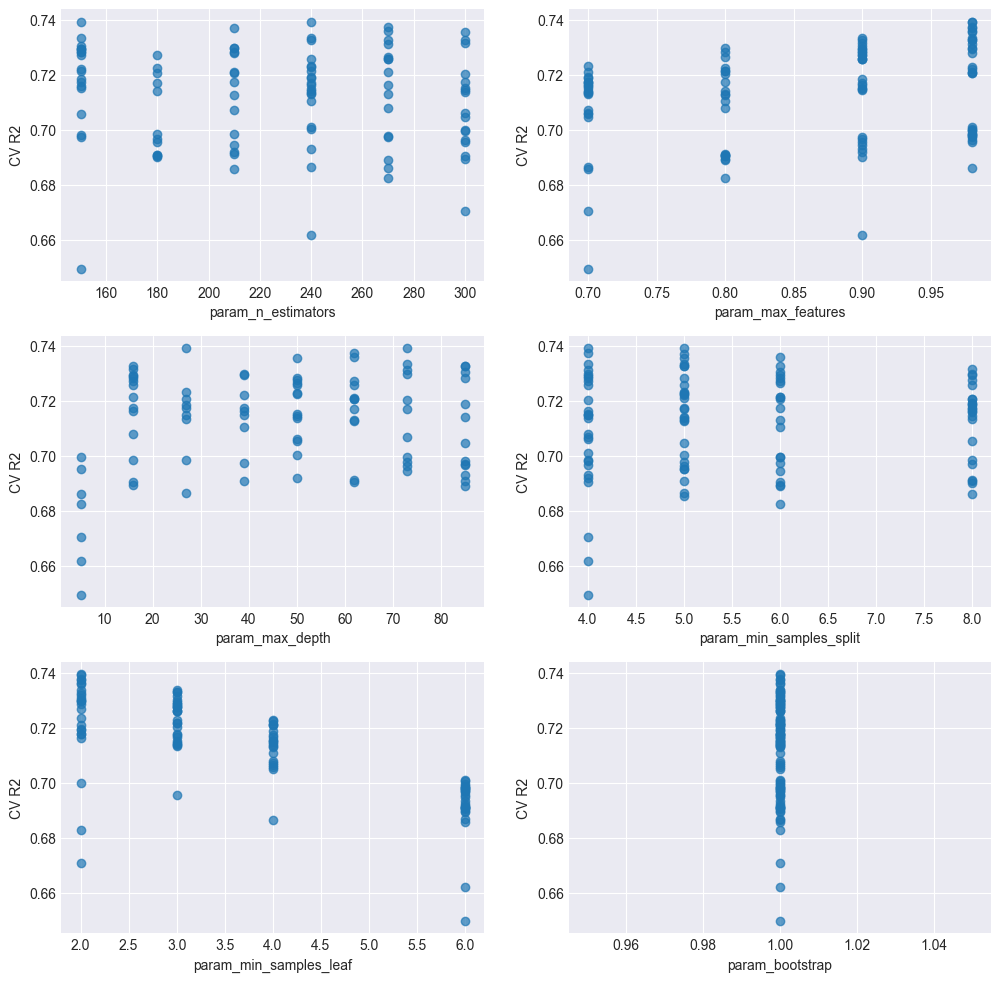

In [167]:
# Visualise the results of the scan
rf_cv_res = pd.DataFrame(rf_profit_hyperparam_tuning_random.cv_results_)

num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):  
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

From these plots we see that not all params in the RanomizedGridSearch seem to have an impact on the performance of the RandomForestRegressor.  
However performances gets better for trees with a higher depth .The model also shows better performance for a higher percentage for max_feature and lower min_samples_leaf. 


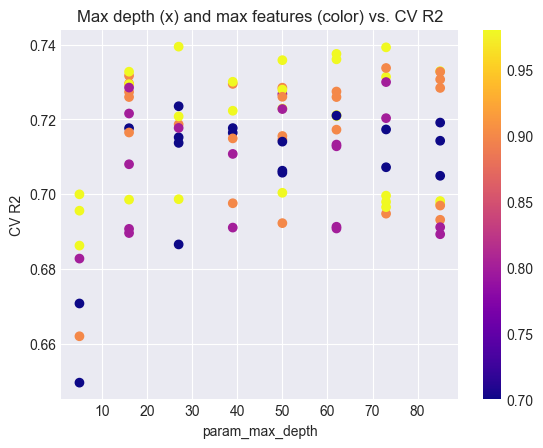

In [168]:
# Plotting hyperparameter vs. performance: more complex plots for the parameters showing some impact
plt.scatter(x=rf_cv_res['param_max_depth'], 
            y=rf_cv_res['mean_test_score'], 
            c=rf_cv_res['param_max_features'], # c argument allows to color according to param_n_estimators
            cmap='plasma');  # This makes the color non-dull
plt.colorbar();  # adds the bar on the right
plt.xlabel('param_max_depth');
plt.ylabel('CV R2');
plt.title('Max depth (x) and max features (color) vs. CV R2');

### Gradient Boost Machine Regression

Below we play around manually with the GradientBoostingRegressor parameters. We first played around a bit manually with the hyperparameters. It was noticed that
- including a limit to the `max_leaf_nodes` does increase test R2, so will include this in hyperparam search
- we have to choose the `n_estimators` (# boosting stages) fairly large it seems, while still keeping learning rate to relatively high value, strange, will optimize further in the hyperparam search

Below is the set we converged upon via manual optimization

In [169]:
gbm_params = {
    'n_estimators': 600,  # number of boosting stages to perform
    'subsample': 1.0,     # 1.0 leads to reduction in variance and increase in bias
    'max_depth': 3,       # limiting the max depth to the default of 3 seems to improve the test R2
    'min_samples_split': 2, # default
    'min_samples_leaf': 1,  # default
    'max_leaf_nodes': 8, # limiting the max number of leaf nodes does increase performance !! improvement of test R2 vs using None
    'learning_rate': 0.1, # default
    'ccp_alpha': 0.0}  # default is 0.0

gbm_profit = GradientBoostingRegressor(loss='squared_error', random_state=seed, **gbm_params) 
gbm_profit.fit(X=X_train, y=y_train) 

# Step 4 - Getting predictions
gbm_preds = gbm_profit.predict(X=X_test)
gbm_preds_train = gbm_profit.predict(X=X_train)

test_R2 = gbm_profit.score(X=X_test, y=y_test)
train_R2 = gbm_profit.score(X=X_train, y=y_train)

# Print R2 results
print(f'Train R2: {train_R2:.3}')
print(f'Test R2: {test_R2:.3}')

Train R2: 0.937
Test R2: 0.845


We noticed a few things : 
- leaving out the 2 outliers in the `outcome_profit` of > 25000 results in a significant increase in Test R2 (0.85 vs. 0.81), so perhaps it is better to leave those values out of the training as it is not certain how representave they are for the final scoring dataset. We can revisit this argument after the hyperparameter scan. 
- we also tried log-transforming the `outcome_profit` feature before fitting (`np.log(1+train_V2["outcome_profit"])`) in order to test whether this would give any improvement, given the fairly skew distribution of the `outcome_profit`values. This resulting in drastically lower test R2 (and also train R2) of 0.65 and 0.86 respectively, so we will not apply any log-transformation here. 
- trying a more outlier robust loss function such as Hubers loss (`huber`) did not improve the estimation (Train R2: 0.922 instread of 0.937, and Test R2: 0.820 instead of 0.845 using a `square_error`loss function

(0.0, 25000.0)

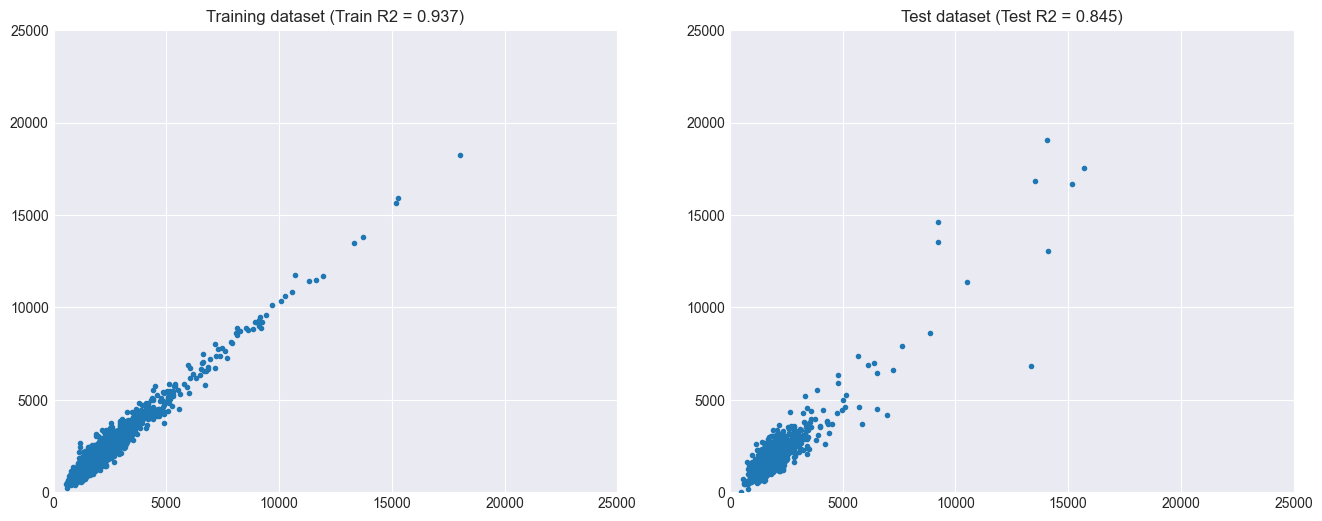

In [170]:
# -- let's make a quick plot of the results for the training & test dataset
axis_range = [0, 25000]
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(gbm_preds_train, y_train, '.')
axs[0].set_title(f"Training dataset (Train R2 = {train_R2:.3})")
axs[0].set_ylim(axis_range)
axs[0].set_xlim(axis_range)

axs[1].plot(gbm_preds, y_test, '.')
axs[1].set_title(f"Test dataset (Test R2 = {test_R2:.3})")
axs[1].set_ylim(axis_range)
axs[1].set_xlim(axis_range)

Let's now try to optimise the manually tweaked hyperparameter further in an automated way using a RandomisedSearchCV, configure below whether you want to load or rescan the final best estimator. 

In [171]:
# -- first choose how many hyperparameters to randomly sample
n_hyperparam_sample = 200

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=200, stop=1000, num=9)],
    'max_depth': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 10, 30],
    'max_leaf_nodes': [int(x) for x in np.linspace(2, 20, num=19)],
    'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1],
    }

if os.path.exists(gbm_profit_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {gbm_profit_scan_filename}")
    gbm_profit_hyperparam_tuning_random = joblib.load(gbm_profit_scan_filename)

else:
    # max_features':  [0.1, 0.3, 0.5, 0.7, 0.9] # not using this one... best leave at default !
    # subsample': [0.4, 0.6, 0.8, 1],

    # Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_profit_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    gbm_profit_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found RF hyperparams after this random search: {gbm_profit_hyperparam_tuning_random.best_params_}")

    # -- and write out
    joblib.dump(value=gbm_profit_hyperparam_tuning_random, 
                filename=gbm_profit_scan_filename)

    print(f"Written : {gbm_profit_scan_filename}")

Re-loading random search from models/gbm_profit_random_search.pkl


In [172]:
print('Optimally found GBM hyperparams after this random search: \n{}' .format(gbm_profit_hyperparam_tuning_random.best_params_))

# -- Refitting final optimal GBM on all training data
gbm_profit_opt_final = gbm_profit_hyperparam_tuning_random.best_estimator_
gbm_profit_opt_final.fit(X=X_train, y=y_train)

# -- Performances
print('Train R2: %.3f' % gbm_profit_opt_final.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_profit_opt_final.score(X=X_test, y=y_test))

Optimally found GBM hyperparams after this random search: 
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_leaf_nodes': 9, 'max_depth': 4, 'learning_rate': 0.08}
Train R2: 0.895
Test R2: 0.832


Let's compare : 

| parameter | manual | randomsearchCV |
| ----------| ------ |---------------|
| n_estimators | 600 | 200 |
| min_samples_split | 2 | 10 |
| min_samples_leaf | 1 | 4 |
| max_leaf_nodes | 8 | 9 |
| max_depth | 3 | 4 |
| learning_rate | 0.1 | 0.08 |

Interestingly we find slightly lower performance than our manual scan. Probably some randomness is involved here and we could play with the test/train split (e.g. going for  15% test, but that is probably too low). Let's look at the learning curve for both approaches to be sure. But it is striking. The optimum in the scan seems to end up at much less boosting stages (200 instead of 600), as well as at lot more `min_samples_split`and `min_samples_leaf`, all of which cause increased bias and reduce variance, apart from the `max_depth`. So the optimised version of the gbm will probably generalise better since judging from the parameters, it should have less variance, but still yield a rather good result. We will choose the optimal model from the scan as the final model then... 



In [173]:
gbm_profit_cv_results = pd.DataFrame(gbm_profit_hyperparam_tuning_random.cv_results_)

Here we make a plot of the scans. We noticed that `param_max_depth == 1` is leading to very poor results, so we filter that out. Iteratively similar procedure for : 
- `param_max_leaf_nodes < 2`
- `param_max_depth = 2`

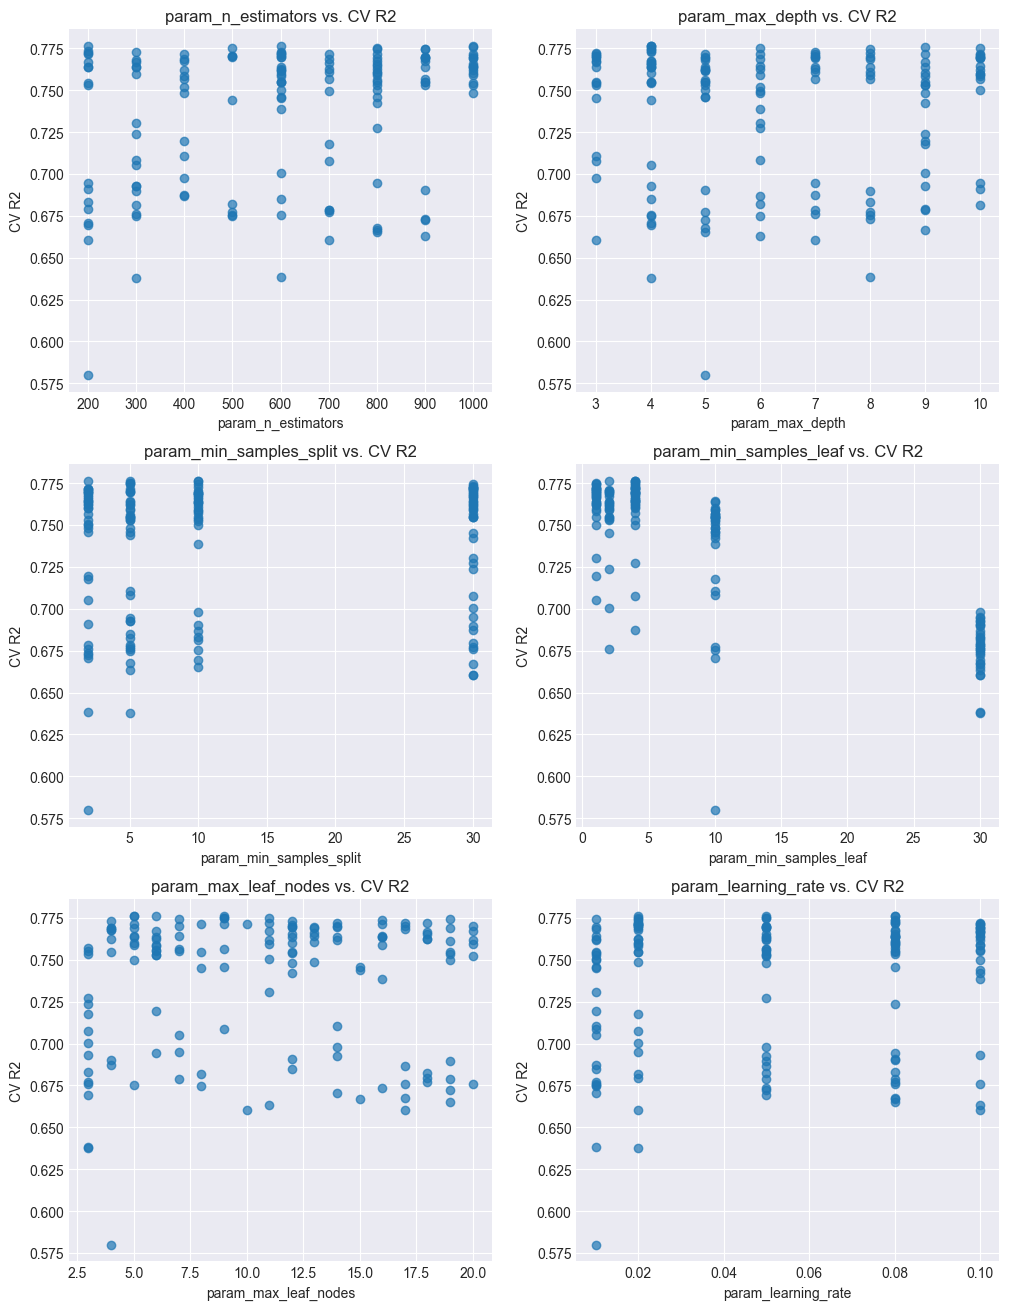

In [174]:
gbm_profit_cv_results = gbm_profit_cv_results[(gbm_profit_cv_results['param_max_depth'] > 1) & (gbm_profit_cv_results['param_max_leaf_nodes'] > 2) & (gbm_profit_cv_results['param_max_depth'] > 2)]
num_keys = len(random_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,16))
for i, param in enumerate([ f"param_{key}" for key in random_grid.keys()]):    
    axs[i//2][i%2].scatter(x=gbm_profit_cv_results[param], y=gbm_profit_cv_results['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_title(f"{param} vs. CV R2")
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

Besides a clear drop in R2 with param_min_leaf, we don't really see any strong dependency. So let's leave our best estimate from before as is.

### Support vector regression

t.b.a.

### Learning curve  

Below we have plotted the learning curve for both the RF as well as the GBM.

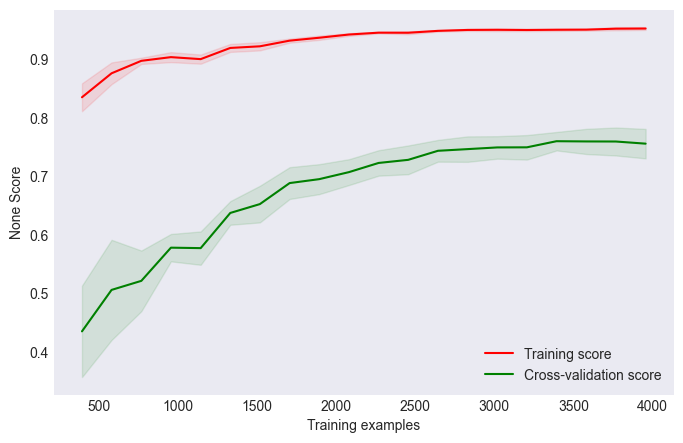

In [175]:
# The learning_curve for our model 
cuf.plot_learning_curve(model=rf_profit_best, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_profit'], 
                    cv=5, 
                    num_show=20)
plt.show()

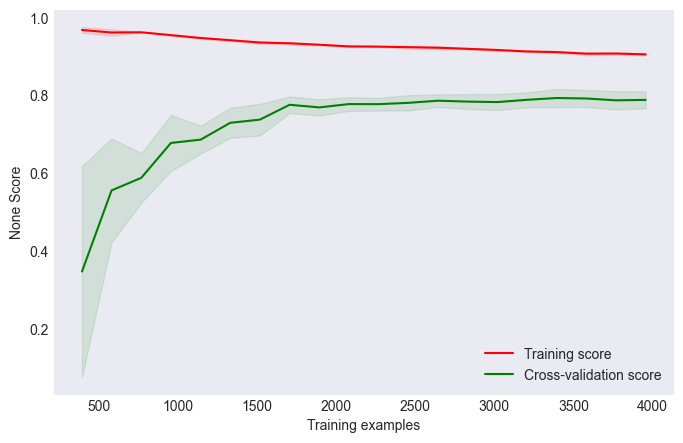

In [176]:
# The learning_curve for our model 
cuf.plot_learning_curve(model=gbm_profit_opt_final, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_profit'], 
                    cv=5, 
                    num_show=20)
plt.show()

We seet that the CV score in case of the RF approach flattens out around 3000 training samples, for the GBM we already see convergence after ~2000 training samples at better performance even. That's striking !

### Final model selection

In [177]:
# -- we select the GBM model
model_profit = gbm_profit_opt_final

## Model to predict the outcome_damage

Now let's turn our attention to predicting the damage amount. The first thing we notice about the distribution of `outcome_damage_amount` is that it contains a lot of 0 values.

Text(0.5, 0, 'outcome_damage_amount')

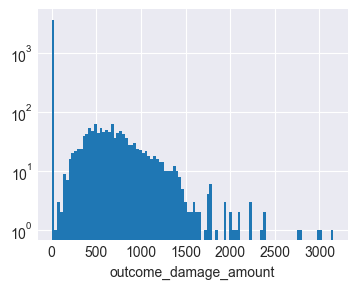

In [178]:
ax = train_V2["outcome_damage_amount"].hist(bins=100, log=True, figsize=(4,3))
ax.set_xlabel("outcome_damage_amount")

We can choose to either leave those in, probably when using a tree-based model, this won't make much difference, but we could also choose to make use of the classifier and first train whether a client will inflict damage or not and if he/she does, then calculate how much. This would correspond to training only on those samples for which the outcome_damage_amount is > 0, and therefore having a more consisten data sample (besides the one individual that managed to inflict only psychological damage (amount 0)). We have chosen the latter and will only train on those records which actually have inflicted damage. 

Therefore, out train / test split will select the instances with larger than 0 damage : 

In [179]:
idx_damage = train_V2[train_V2["outcome_damage_amount"] > 0].index

In [180]:
X_train, X_test, y_train, y_test = train_test_split(train_V2.loc[idx_damage].drop(target_features, axis=1), 
                                                    train_V2.loc[idx_damage,"outcome_damage_amount"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

### Random Forest Model

In [181]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
# n_estimators = [int(x) for x in np.linspace(start=100, stop=300, num=10)] 
# max_features = [int(x) for x in np.linspace(start=5, stop=50, num=8)] 
# max_depth = [int(x) for x in np.linspace(start=2, stop=100, num=10)]
# max_depth.append(None)  # adding 'None' option as well
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4, 10]

n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]

bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

if os.path.exists(rf_damage_scan_filename) and not overwrite_model_training:
    # -- re-load the scan from disc
    print(f"Re-loading the scan from {rf_damage_scan_filename}")
    rf_damage_hyperparam_tuning_random = joblib.load(rf_damage_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestRegressor()

    # Initializing random search CV object
    rf_damage_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_damage_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- write the scan to file
    joblib.dump(
        value=rf_damage_hyperparam_tuning_random, 
        filename=rf_damage_scan_filename)
    
    print(f"Saved scan result to : {rf_damage_scan_filename}")


Re-loading the scan from models/rf_damage_random_search.pkl


In [182]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_damage_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damage_best = rf_damage_hyperparam_tuning_random.best_estimator_
rf_damage_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damage_best_y_train_pred = rf_damage_best.predict(X=X_train)
rf_damage_best_y_test_pred = rf_damage_best.predict(X=X_test)


# Checking accuracy manually
print('Train R2: %.3f' % rf_damage_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_damage_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: 
{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.8, 'max_depth': 27, 'bootstrap': True}
Train R2: 0.561
Test R2: 0.138


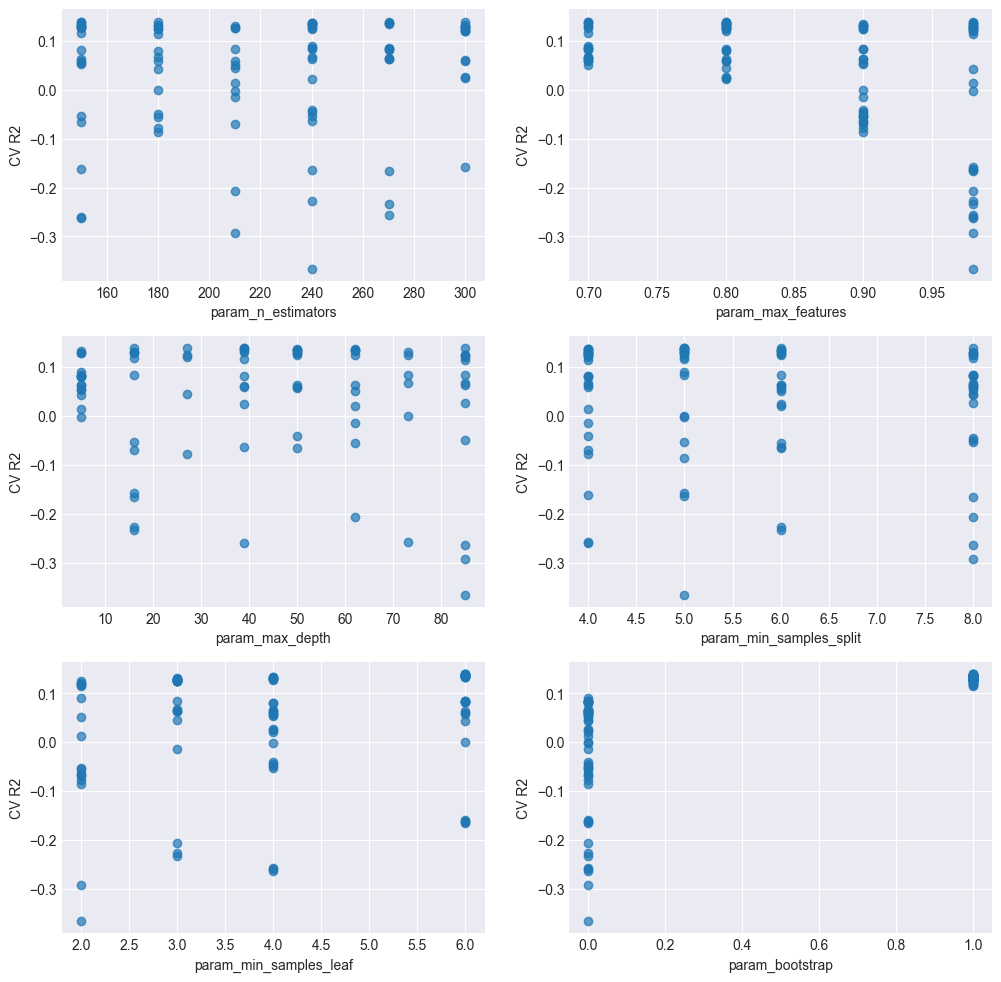

In [183]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_damage_hyperparam_tuning_random.cv_results_)


num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):    
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)    
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

### Gradient Boost Machine Regression

In [184]:

# -- first chooe how many hyper parameters to randomly sample
n_hyperparam_sample = 500

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=200, stop=1000, num=18)],
    'max_depth': [int(x) for x in np.linspace(1, 20, num=10)],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 20, 30, 40, 50, 60],
    'max_leaf_nodes': [int(x) for x in np.linspace(2, 20, num=19)],
    'learning_rate': [0.005, 0.007, 0.01, 0.012, 0.015],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1],
    'max_features':  [0.1, 0.3, 0.5, 0.7, 0.9]
    }


if os.path.exists(gbm_damage_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {gbm_damage_scan_filename}")
    gbm_damage_hyperparam_tuning_random = joblib.load(gbm_damage_scan_filename)

else:
    # Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_damage_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    gbm_damage_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found RF hyperparams after this random search: {gbm_damage_hyperparam_tuning_random.best_params_}")

    # -- and write out
    joblib.dump(value=gbm_damage_hyperparam_tuning_random, 
                filename=f"gbm_damage_random_search.pkl")

    print(f"Written scan to : {gbm_damage_scan_filename}")


Re-loading random search from models/gbm_damage_random_search.pkl


In [185]:
# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {gbm_damage_hyperparam_tuning_random.best_params_}")

# -- Refitting final optimal GBM on all training data
gbm_damage_opt_final = gbm_damage_hyperparam_tuning_random.best_estimator_
gbm_damage_opt_final.fit(X=X_train, y=y_train)

# -- Performances
print('Train R2: %.3f' % gbm_damage_opt_final.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_damage_opt_final.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: {'subsample': 0.2, 'n_estimators': 717, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_features': 0.3, 'max_depth': 9, 'learning_rate': 0.007}
Train R2: 0.446
Test R2: 0.154


In [186]:
gbm_damage_cv_results = pd.DataFrame(gbm_damage_hyperparam_tuning_random.cv_results_)

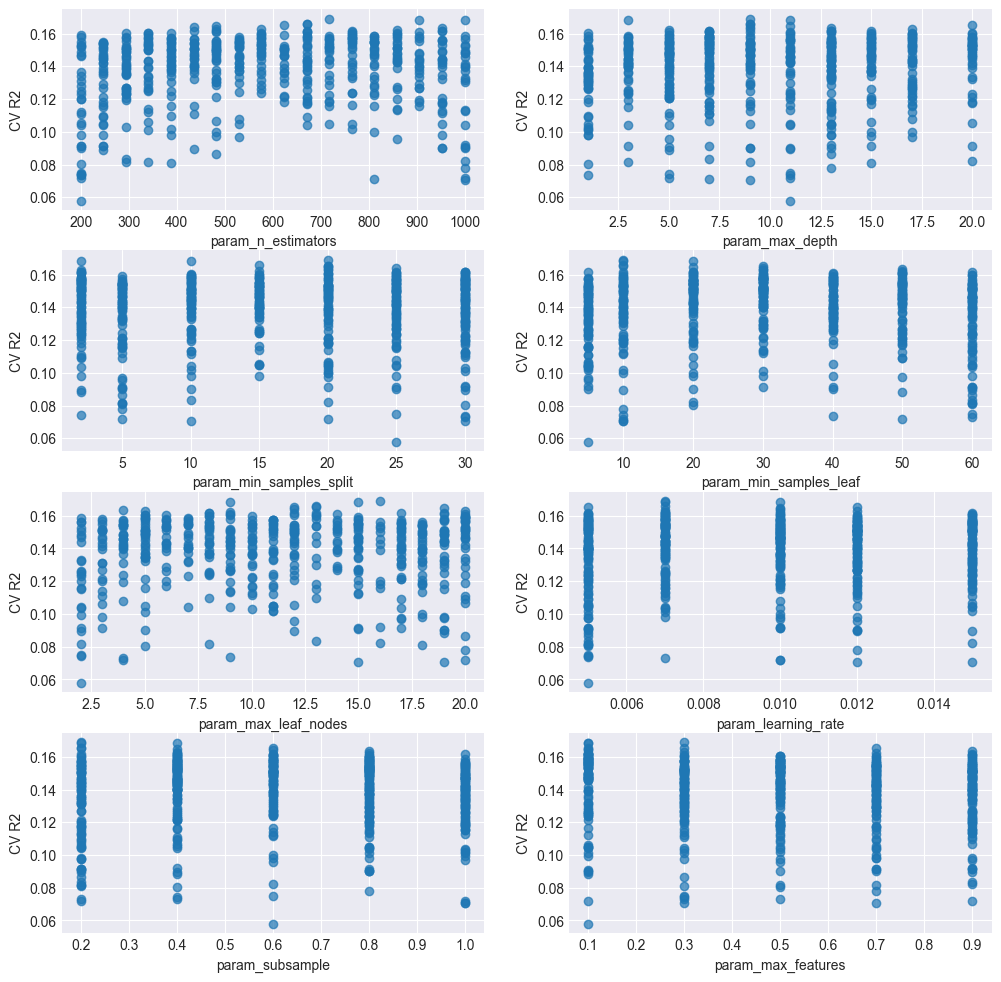

In [187]:
num_keys = len(random_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in random_grid.keys()]):    
    axs[i//2][i%2].scatter(x=gbm_damage_cv_results[param], y=gbm_damage_cv_results['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

Text(0.5, 0, 'Target')

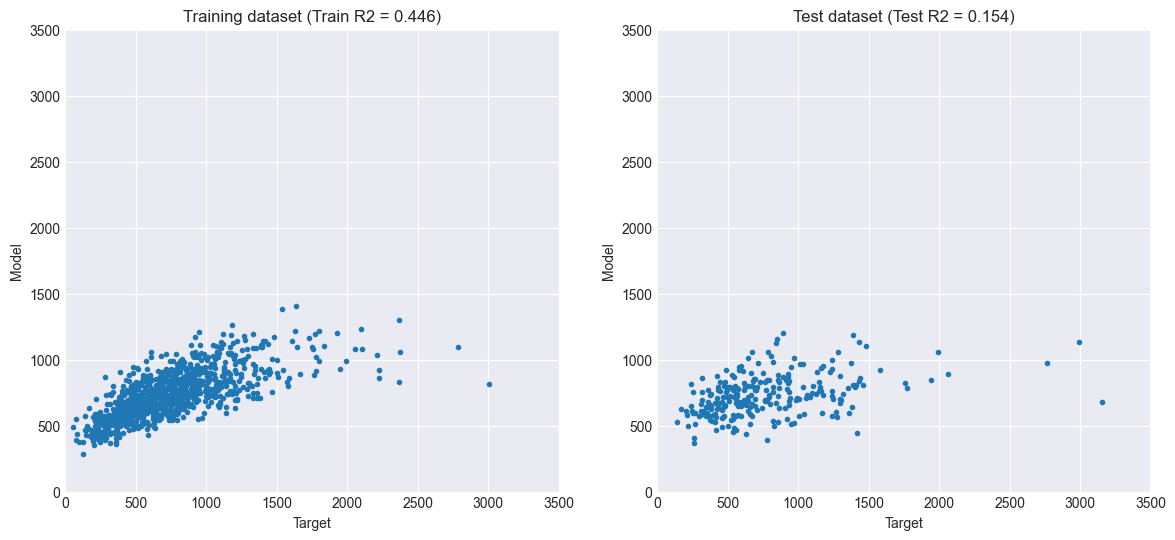

In [188]:
# -- let's make a quick plot of the results for the training & test dataset
axis_range = [0, 3500]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(y_train, gbm_damage_opt_final.predict(X_train), '.')
axs[0].set_title(f"Training dataset (Train R2 = {gbm_damage_opt_final.score(X=X_train, y=y_train):.3})")
axs[0].set_ylim(axis_range)
axs[0].set_xlim(axis_range)
axs[0].set_ylabel("Model")
axs[0].set_xlabel("Target")

axs[1].plot(y_test, gbm_damage_opt_final.predict(X_test), '.')
axs[1].set_title(f"Test dataset (Test R2 = {gbm_damage_opt_final.score(X=X_test, y=y_test):.3})")
axs[1].set_ylim(axis_range)
axs[1].set_xlim(axis_range)
axs[1].set_ylabel("Model")
axs[1].set_xlabel("Target")

These graphs are not very encouraging. We especcially see that for a number of high-damage cases, the damage values are underestimated. Perhaps this is related to the fact that we omitted some outiers, but still this was done only for 2 values. From the plots above it would seem that perhaps they can be rectified a little by fitting a linear correction to the training dataset and then applying it to the test and subsequent score dataset, but this was tried and did not yield better R2. We leave it as it is for now. 

### Final model selection

Here we noticed that the GBM does not offer much improvement w.r.t. the standard Random Forest technique. In both cases we get reasonable R2 on the training dataset (order 0.45 - 0.55), but consistenly, the test R2 does not yield much more than 0.14 - 0.15, which is not very encouraging. 

In [189]:
# -- select best model for predicting damage if damage occurs
model_damage = gbm_damage_opt_final

## Model to predict the outcome_revenu

As we noticed that predicting the damage is rather difficult, yieling low R2 in our analyss, we investigate whether directly predicting the revenu, i.e. `outcome_profit - outome_damage_amount` is not a better strategy. 

In [192]:
# -- first produce a train/test set again on the 
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_revenue"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

### Random Forest Model

In [194]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=10)]  # list comprehension because we want integers!
max_depth = [int(x) for x in np.linspace(start=5, stop=80, num=5)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.85, 0.9, 0.95]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

if os.path.exists(rf_revenu_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {rf_revenu_scan_filename}")
    rf_revenu_hyperparam_tuning_random = joblib.load(rf_revenu_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestRegressor()

    # Initializing random search CV object
    rf_revenu_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                                     param_distributions=hyperparam_grid, 
                                                     n_iter=n_hyperparams_sample, 
                                                     cv=kfold,
                                                     verbose=2, 
                                                     random_state=seed, n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_revenu_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=rf_revenu_hyperparam_tuning_random, 
                filename=rf_revenu_scan_filename)
    
    print(f"Written random search to {rf_revenu_scan_filename}")

Re-loading random search from models/rf_revenu_random_search.pkl


In [195]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_revenu_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_revenu_best = rf_revenu_hyperparam_tuning_random.best_estimator_
rf_revenu_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_revenu_best_y_train_pred = rf_revenu_best.predict(X=X_train)
rf_revenu_best_y_test_pred = rf_revenu_best.predict(X=X_test)

# Checking score (R2) manually
print('Train R2: %.3f' % rf_revenu_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_revenu_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: 
{'n_estimators': 233, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 80, 'bootstrap': True}
Train R2: 0.863
Test R2: 0.726


This is not too bad actually, let's look at the GBM again as well. 

### Gradient Boosting Machine Regression

As always, we first played around manually with the parameter settings, which subsequently resulted in the following scan ranges for the random grid. 

In [196]:
# -- first chooe how many hyper parameters to randomly sample
n_hyperparam_sample = 500

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=300, stop=1000, num=8)],
    'max_depth': [int(x) for x in np.linspace(2, 20, num=11)],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_leaf_nodes': [5, 10, 15, 20],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'subsample': [0.4, 0.6, 0.8, 1]
    }

    # max_features : best when 1.0 it was found

if os.path.exists(gbm_revenu_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {gbm_revenu_scan_filename}")
    gbm_revenu_hyperparam_tuning_random = joblib.load(gbm_revenu_scan_filename)

else:
    # Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_revenu_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    gbm_revenu_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=gbm_revenu_hyperparam_tuning_random, 
                filename=gbm_revenu_scan_filename)

    print(f"Written {gbm_revenu_scan_filename}")

Re-loading random search from models/gbm_revenu_random_search.pkl


In [197]:
# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {gbm_revenu_hyperparam_tuning_random.best_params_}")

# Refitting the optimal model on the whole training dataset
gbm_revenu_best = gbm_revenu_hyperparam_tuning_random.best_estimator_
gbm_revenu_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
gbm_revenu_best_y_train_pred = gbm_revenu_best.predict(X=X_train)
gbm_revenu_best_y_test_pred = gbm_revenu_best.predict(X=X_test)

# Checking score (R2) manually
print('Train R2: %.3f' % gbm_revenu_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_revenu_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: {'subsample': 0.8, 'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 15, 'max_depth': 3, 'learning_rate': 0.04}
Train R2: 0.859
Test R2: 0.800


We notice that the training R2 is more or less of the same order as the RF approach, however the test R2 is noticable better, so we again decide that the GBM yields the best result here. We will leave it at that for the moment. 

### Final model selection

In [198]:
# -- select the GBLM model 
model_revenue = gbm_revenu_best

## Classifier to predict which clients will cause damage

In this part we train a classifier to identify which clients will cause damages. Note that apparently a single person managed to inflict `damage`, but with 0 damage amount. Let's assume that not all damage can be quantified in hard currency :) and continue with `outcome_damage_inc` as indicator, leaving in this person.  

A few questions we should consider : 

First of all, let's take a look to the plots below, where we can see on the one hand side that there is a significant imbalance between the 2 classes : 74 % of the guest don't inflict any damage, whereas 26 % do inflict damage. So 3 times as many guests inflict no damage vs. the ones that do. Though the discrepancy is not extreme, it may be worthwhile to deal with this imbalance in the training. First we should note that given this imbalance, we should probably better not just optimize for accuracy in the traingin as this can give misleading results as the model evaluation will be dominated by it's skill in predicting the majority class. We will therefore treat the imbalance via minority over-sampling. We will not try to introduce synthetic samples (SMOTE) out of fear this may negatively impact the training, but stick to simply oversamping the guests causing damage. Afterall, we have already seen that creating amodel for the damage amount is not easy, so let's not try to confusing things with synthetic samples. 

In [201]:
# -- note that there is one particular individual which managed to inflict only emotional damage as well
train_V2[(train_V2['outcome_damage_inc'] == 1) & (train_V2["outcome_damage_amount"] == 0) ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc,outcome_revenue
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1708,2169.0,778.0,2308.0,0.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,3.0,0.0,27725.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,287.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,0.0,0.0,0.981625,0.183575,1.0,1.0,1062.86,0.0,1,1062.86


In [199]:
train_V2['outcome_damage_inc'].value_counts(normalize=True)

outcome_damage_inc
0    0.744388
1    0.255612
Name: proportion, dtype: float64

Text(0.5, 1.0, 'outcome_profit')

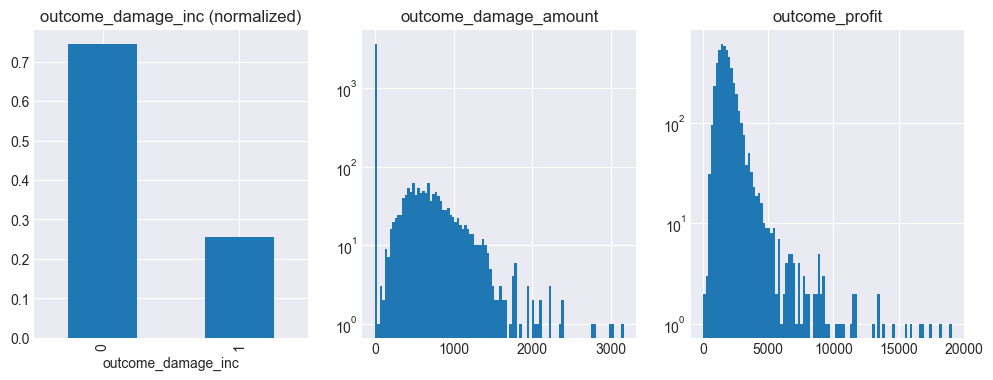

In [200]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
train_V2['outcome_damage_inc'].value_counts(normalize=True).plot(kind='bar', ax=axs[0])
train_V2['outcome_damage_amount'].hist(ax=axs[1], bins=100, log=True)
train_V2['outcome_profit'].hist(ax=axs[2], bins=100, log=True)
axs[0].set_title("outcome_damage_inc (normalized)")
axs[1].set_title("outcome_damage_amount")
axs[2].set_title("outcome_profit")

In addition, we should stop to think on what metric in training is more relevant to optimise. We already established that optimizing for accuracy is not the best strategy given the imbalance in the dataset.  Clearly, both false positive and false negatives are undesirable, however there is a clear difference in the implications. We can see in the distribution of the damage outcome that costs are roughly around 1000 EUR, whereas the most likely profit is say round 2000 EUR, so when damage occurrs, it's often a considerable fraction of the profit. So there is a non-negligeable cost associated with missing guests who inflict damage.

To put it more clearly : 

- If the cost of wrongly predicting that a guest will cause damage (false positive) is high (e.g., unnecessary precautions that are costly or offend guests), then we would want to optimize for high precision. This ensures that when we do predict damage, we are more likely to be correct. Wrongly predicting that a guest will cause damage does however not impact our revenu (if we disregard the long term psychological effects and disgruntled guests & want to go for short term profit that is...). 

- If the cost of missing a guest who will cause damage (false negative) is high (e.g., severe damage and associated costs, which we kinda established above), then we would want to optimize for high recall. This ensures that we capture most of the guests who are likely to cause damage, even if it means having more false positives (and offending guest). Also, from a profit perspective, if we miss a guest that will cause damage, this impacts our revenu with the amount of damage caused. 

This may depend somewhat on the correlation between the profit and the damage. If we risk offending high profit guests, then optimizing for recall may turn against us. 

We may consider to optimize for the F1 score instead to have a balance between precision & recall, but since we're dealing with Russian hotel guests and not West-Europeans, chances are probably smaller that they will be offended by some bluntness from the hotel staff and by ubiquituous CCTV installations ;-). And afterall we do prefer to maximize the revenu. 

In the absence of the hotel management to discuss with, let's go for optimizing recall...

Whether we first do train/test split and then oversample or vice versa is subject of debate. if we first do the train/test split, we should probably be sure that the fraction of positives in both datasets is roughly the same, so we print out the  `value_counts()` to check. 

In [203]:
# -- again we get the train test split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), # features DF
                                                    train_V2['outcome_damage_inc'],   # target DF/series
                                                    test_size=0.2,
                                                    shuffle=True,  
                                                    random_state=seed)  

print("Counts for every outcome in training dataset : ")
print(y_train.value_counts())
print("Counts for every outcome in test dataset : ")
print(y_test.value_counts())


Counts for every outcome in training dataset : 
outcome_damage_inc
0    2942
1    1014
Name: count, dtype: int64
Counts for every outcome in test dataset : 
outcome_damage_inc
0    739
1    250
Name: count, dtype: int64


Now we oversample the training dataset, but not the test dataset, we will keep that separate for reporting. 

In [204]:
# sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=seed)
sm = RandomOverSampler(sampling_strategy='auto', random_state=seed)

# Call fit_resample() to do actual sampling using training data
X_train_smote, y_train_smote = sm.fit_resample(X=X_train, y=y_train) 

print("Counts for every outcome after synthetic oversampling: ")
y_train_smote.value_counts()

Counts for every outcome after synthetic oversampling: 


outcome_damage_inc
0    2942
1    2942
Name: count, dtype: int64

### Baseline logistic regression

Below we establish a baseline simple logistic regression to see how much added value the more compelx methods have. 

In [241]:
from sklearn import linear_model

In [244]:
# -- we need to rescale here...
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_v2_stan_df.drop(target_features, axis=1), 
                                                    train_V2["outcome_damage_inc"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

regl = linear_model.LogisticRegression()
regl.fit(X_train_d, y_train_d)

print(regl.score(X_train_d, y_train_d))
print(regl.score(X_test_d, y_test_d))

LogisticRegression()

0.7591001011122346
0.756319514661274


In [247]:
print(recall_score(y_train_d, regl.predict(X_train_d)))
print(recall_score(y_test_d, regl.predict(X_test_d)))

0.14792899408284024
0.108


### Random Forest Classifier

First we will again try to apply a random forest classifier, here we will **not** apply it to the resampled dataset. 

In [257]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
# n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
# max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
# max_depth = [int(x) for x in np.linspace(start=2, stop=40, num=10)]
# max_depth.append(None)  # adding 'None' option as well
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4, 10]

n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]

bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}


if os.path.exists(rfc_damage_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {rfc_damage_scan_filename}")
    rfc_damage_hyperparam_tuning = joblib.load(rfc_damage_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestClassifier()

    # Initializing random search CV object
    rfc_damage_hyperparam_tuning = RandomizedSearchCV(estimator=rf, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Executing / fitting the random search 
    rfc_damage_hyperparam_tuning.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=rfc_damage_hyperparam_tuning, 
                filename=rfc_damage_scan_filename)

    print(f"Written {rfc_damage_scan_filename}")

Re-loading random search from models/rfc_damage_random_search.pkl


In [258]:
print('Optimal hyperparameter values according to our random search: \n{}' .format(rfc_damage_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rfc_damage_best = rfc_damage_hyperparam_tuning.best_estimator_
rfc_damage_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rfc_damage_best_y_train_pred = rfc_damage_best.predict(X=X_train)
rfc_damage_best_y_test_pred = rfc_damage_best.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rfc_damage_best.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_damage_best.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rfc_damage_best_y_test_pred, target_names=target_names))

Optimal hyperparameter values according to our random search: 
{'n_estimators': 240, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.98, 'max_depth': 5, 'bootstrap': True}


Train accuracy of the refitted model: 0.770
Test accuracy of the refitted model: -2808671.066
              precision    recall  f1-score   support

   no damage       0.76      0.98      0.85       739
      damage       0.50      0.07      0.12       250

    accuracy                           0.75       989
   macro avg       0.63      0.52      0.49       989
weighted avg       0.69      0.75      0.67       989



We see some disturbing results here. First of all, the recall for damage is very low, so this best accuracy model has almost no skill in identifying the guests who will cause damage. Also, the accuracy of the test model seems to be very large and negative, which obviously is not what we want. So, something must have gone wrong in the training here. Besides the clear need for bootstrapping, we don't really expect any better performance from further optimizing the parameters.

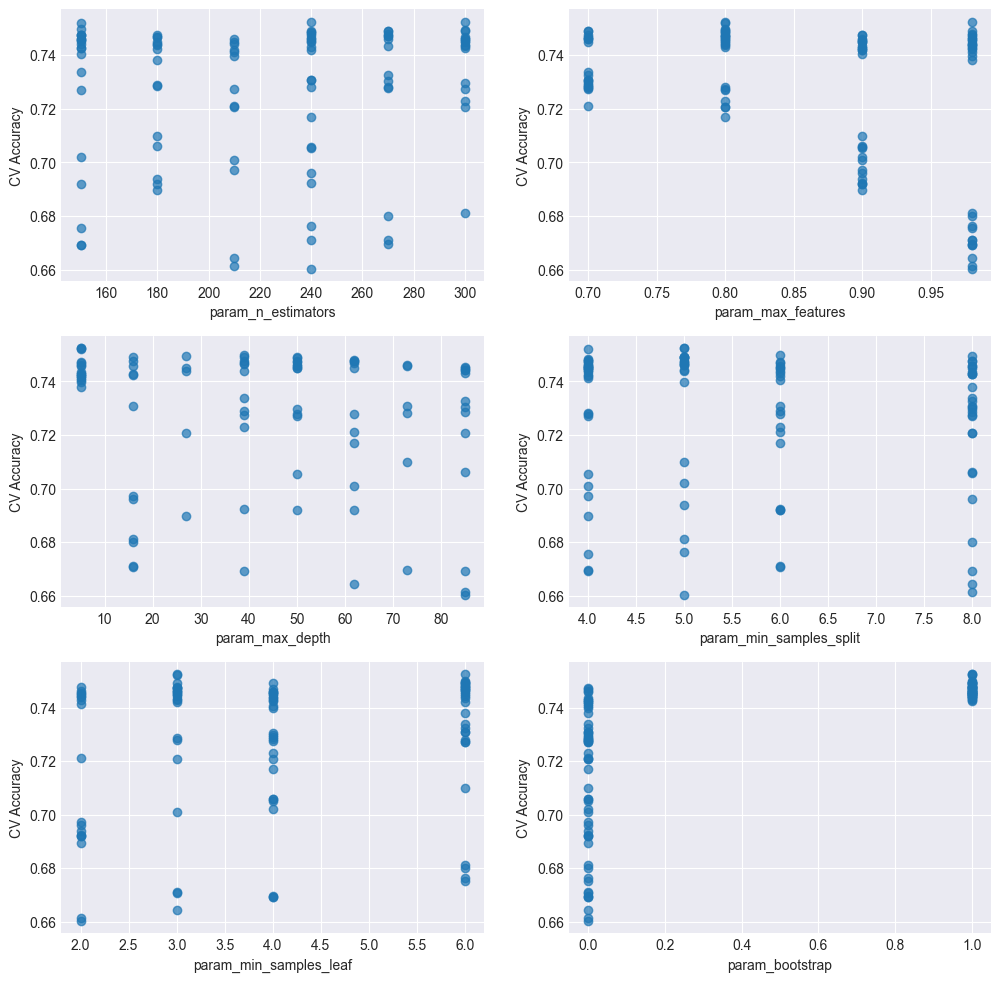

In [210]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rfc_damage_hyperparam_tuning.cv_results_)

# Scatter plot of selection of hyperparams vs performance
num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):    
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV Accuracy')

### Gradient Boosting Machine Classifier

Instead, we will try again to resort to a Gradient Boosting classifier, but **we will also include the resampled** dataset in the training to equalize the classes in the training dataset and in addition, we will modify the `scoring` parameter in the CV search to yield the best recall on the damage instead of optimizing for accuracy.

So now we have a balanced dataset between the damage & no-damage events. Let's process to train the classifier, let's do a random search to start with. At first, we tried putting in the `recall` option for the `scoring` kwarg, however this seemed to overfit : recall of 0.99 on the training dataset, but only 0.29 on the test dataset. In hindsight, this is probably logical as the model pushes the TP or FN in the right direction, so a balanced metric for optimisation is probably more usefull, so leave at default or try 'F1' ? Interestingly, this too did not seem to work (the recall on the training dataset is very much overfitted : 1.0, as opposed to 0.16 on the test dataset)), likely since we have already resampled the dataset. We also tried So we will train / scan the classifiers using the default accuracy, but try to optimise for recall in the precision recall curve.

In [230]:
gbmc_damage_scan_filename = os.path.join( 'models', 'gbmc_damage_random_search_recall.pkl' )
#gbmc_damage_scan_filename = os.path.join( 'models', 'gbmc_damage_random_search_recall_no_resampling.pkl' )
#gbmc_damage_scan_filename = os.path.join( 'models', 'gbmc_damage_random_search_accuracy.pkl' )

In [231]:
# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 200

# Defining grid of candidate values to sample from
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=50)]
learning_rate = [x for x in np.logspace(start=-3, stop=-0.01, num=50)]  # Important for GBM!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
hyperparam_grid = {'n_estimators': n_estimators,
                   'learning_rate': learning_rate,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'subsample': subsample}

if os.path.exists(gbmc_damage_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {gbmc_damage_scan_filename}")
    gbmc_damage_hyperparam_tuning = joblib.load(gbmc_damage_scan_filename)

else:
    # Data splitter setup
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Running random search
    gbmc_damage = GradientBoostingClassifier(loss='log_loss', random_state=seed)
    gbmc_damage_hyperparam_tuning = RandomizedSearchCV(estimator=gbmc_damage, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold, 
                                            verbose=2, 
                                            scoring='recall',# scoring='recall' to optimise for recall                                          
                                            random_state=seed, 
                                            n_jobs=-1)  # get best recall as score on the damaged case

    # Executing / fitting the random search CV on the resampled dataset
    gbmc_damage_hyperparam_tuning.fit(X=X_train_smote, y=y_train_smote)


    # -- and write out
    joblib.dump(value=gbmc_damage_hyperparam_tuning, 
                filename=f"gbmc_damage_random_search.pkl")

    print(f"Written scan to : {gbmc_damage_scan_filename}")

Re-loading random search from models/gbmc_damage_random_search_recall.pkl


In [232]:
print('GBM best hyperparameter values according to random search: {}' .format(gbmc_damage_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
gbmc_damage_opt1 = gbmc_damage_hyperparam_tuning.best_estimator_
gbmc_damage_opt1.fit(X=X_train_smote, y=y_train_smote)
#gbmc_damage_opt1.fit(X=X_train, y=y_train)

# Getting predictions on original train and test set, not the resampled dataset...
gbmc_damage_opt1_y_train_pred = gbmc_damage_opt1.predict(X=X_train)
gbmc_damage_opt1_y_test_pred = gbmc_damage_opt1.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % gbmc_damage_opt1.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % gbmc_damage_opt1.score(X=X_test, y=y_test))


print('Train recall of the refitted model: %.3f' % recall_score(y_pred=gbmc_damage_opt1_y_train_pred, y_true=y_train))
print('Test recall of the refitted model: %.3f' % recall_score(y_pred=gbmc_damage_opt1_y_test_pred, y_true=y_test))

GBM best hyperparameter values according to random search: {'subsample': 0.8, 'n_estimators': 595, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': 4, 'learning_rate': 0.2397705935482644}
Train accuracy of the refitted model: 0.999
Test accuracy of the refitted model: 0.695
Train recall of the refitted model: 0.999
Test recall of the refitted model: 0.292


In [233]:
# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=gbmc_damage_opt1_y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.78      0.83      0.80       739
      damage       0.37      0.29      0.33       250

    accuracy                           0.69       989
   macro avg       0.57      0.56      0.56       989
weighted avg       0.67      0.69      0.68       989



In [249]:
# Decision cutoff/threshold tuning for classification models
# Choose a cutoff/threshold value
cutoff = 0.3

# Refitting an RF with the tuned hyperparameters from the previous cell
print(f"Checking parameters : {gbmc_damage_opt1}")

# Getting performances & classification report
print('Train accuracy: %.3f' % gbmc_damage_opt1.score(X=X_train, y=y_train))
print('Test accuracy: %.3f' % gbmc_damage_opt1.score(X=X_test, y=y_test))
target_names = ['No damage', 'Damage']
print(classification_report(y_test, (gbmc_damage_opt1.predict_proba(X=X_test)[:, 1] > cutoff), target_names=target_names))

Checking parameters : GradientBoostingClassifier(learning_rate=0.2397705935482644, max_depth=4,
                           max_features=12, min_samples_leaf=2,
                           min_samples_split=5, n_estimators=595,
                           random_state=43, subsample=0.8)
Train accuracy: 0.999
Test accuracy: 0.695
              precision    recall  f1-score   support

   No damage       0.79      0.73      0.76       739
      Damage       0.35      0.44      0.39       250

    accuracy                           0.65       989
   macro avg       0.57      0.58      0.58       989
weighted avg       0.68      0.65      0.67       989



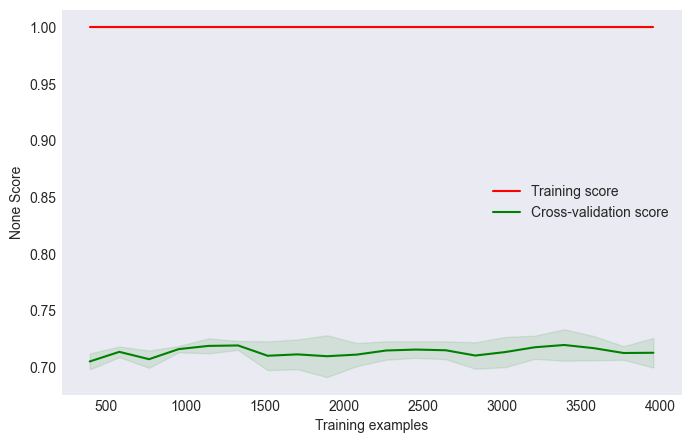

In [235]:
# The learning_curve for our model
cuf.plot_learning_curve(model=gbmc_damage_opt1, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_damage_inc'], 
                    cv=5, 
                    num_show=20)
plt.show()

#### Probability of damage


Setting Decision Threshold

In the context of our problem we want to select the applicants that will generate the highest revenue. Whether they do or do not cause damage is less important, therefore we will look at precision rather than recall. Precision measures the accuracy of the selected cases, specifically the proportion of selected cases that are relevant (in this case, generating high revenue).

For models that output a continuous probability-like value (basically: most models except SVM), the predict function really just applies a cut-off of 0.5 to the predicted values returned from the model. In cases like this where there is class imbalance, probabilities will only start to deviate from the imbalanced 30% once the model has good separation of classes. In the absence of that, 0.5 is definitely not the best cutoff. This leads to e.g. a recall of 0.0. You will in fact see that many of the algorithms in this practical get both precision and recall of the expensive class equal to 0, which means that no instance is classified as expensive with the default cutoff of 0.5.

In [ ]:
# Decision cutoff/threshold tuning for classification models
# Choose a cutoff/threshold value
cutoff = 0.15

# Refitting an RF with the tuned hyperparameters from the previous cell
print(f"Checking parameters of rf_damageInd: {rf_damageInd}")

# Getting performances & classification report
print('Train accuracy: %.3f' % rf_damageInd.score(X=X_train, y=y_train))
print('Test accuracy: %.3f' % rf_damageInd.score(X=X_test, y=y_test))
target_names = ['No damage', 'Damage']
print(classification_report(y_test, (rf_damageInd.predict_proba(X=X_test)[:, 1] > cutoff), target_names=target_names))

RECALL:
 It measures the ability of a model to correctly identify all relevant instances within a dataset. Mathematically, recall is calculated as the number of true positive predictions divided by the sum of true positives and false negatives. It is also known as sensitivity or true positive rate. A high recall value indicates that the model is good at identifying all positive instances in the dataset.

PRECISION
 It measures the proportion of true positive predictions out of all positive predictions made by the model. Mathematically, precision is calculated as the number of true positive predictions divided by the sum of true positives and false positives. A high precision value indicates that when the model predicts a positive result, it is likely to be correct.

the F1 score is a metric that combines both precision and recall into a single value. It is calculated as the harmonic mean of precision and recall. The F1 score provides a balance between precision and recall, giving equal weight to both metrics. A high F1 score indicates that the model has both good precision and recall, making it a useful metric for evaluating the overall performance of a classification model.

In [ ]:
 # Confusion matrix for random forest
rf_damage_pred_proba = rf_damageInd.predict_proba(X_test)


# If you sum per row you just get 1, to know which proability is what, they are ordered as in the classes_ attribute
print(f"Ordering of the target classes: {rf_damageInd.classes_}")  # So False for col 0, True for col1!

# cleaner since col 2 is 1 - col1:
rf_damageInd_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=rf_damageInd_y_test_pred)
print(rf_damageInd_confusion_matrix)

In [ ]:
# Plotting decision cutoff vs. precision
# Making a grid of potential cutoff values (between 0, 1)
cutoffs = np.arange(1, 101) / 100  # Range of cutoffs

# Getting the test precisions with  list comprehension (could be a loop as well)
precisions = [y_test[rf_damage_pred_proba[:,1] > c].mean() for c in cutoffs]
#[rf_damageInd.predict_proba(X=X_test)[:,1] > c].mean() is a way to get the proportion of positively predicted values

# Plotts
plt.figure();
plt.plot(cutoffs, precisions);
plt.xlabel('Cutoff');
plt.ylabel('Precision (PPV)');
plt.title('Potential cutoffs versus resulting test precisions');

#### Calibration

To assess the calibration of a Random Forest Classifier and determine if the predicted probabilities are accurate, you can use a calibration curve. This curve compares the predicted probabilities to the actual outcomes. By plotting the predicted probabilities against the true probabilities, you can visually inspect the calibration of your model.

By examining this calibration curve, you can determine if the predicted probabilities align well with the actual outcomes. If the curve is close to the diagonal line (perfect calibration), it indicates that the model's predicted probabilities are accurate.

In [ ]:
# Calibration curve 
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(estimator=rf_damageInd,
                                  X=X_test, 
                                  y=y_test,
                                  n_bins=5,
                                  strategy='uniform');

The prediction of the probability is close to the measured probability for the lower probabilities. For higher probabilities there is a lack of fit. 

In [ ]:
# Calibrating a RF model
# Importing necessary classes and function
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Doing isotonic regression on our RF model
rf_damageInd_isotonic = CalibratedClassifierCV(estimator=rf_damageInd, 
                                          cv='prefit', 
                                          method='isotonic')
rf_damageInd_isotonic.fit(X=X_test, y=y_test)

# Checking calibration curve on the calibration set
y_test_calibrated = rf_damageInd_isotonic.predict_proba(X=X_test)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_test, probas_list=[y_test_calibrated], n_bins=10);
# plt.title('Calibration Curve on test set - CALIBRATED');
### ERROR on gctmap attribute in matplotlib? module 'matplotlib.cm' has no attribute 'get_cmap'

# Alternative way of plotting
first, second = calibration_curve(y_true=y_test, y_prob=y_test_calibrated, n_bins=20)  # Returns 2 arrays
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(first, second, marker='.')
plt.title('Calibration Curve on test set - CALIBRATED')
plt.show()

In [ ]:
# Calibration curve after isotonic regression
y_pred_train_calibrated = rf_damageInd_isotonic.predict_proba(X=X_train)[:, 1]
y_pred_train_uncalibrated = rf_damageInd.predict_proba(X=X_train)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_calibrated], n_bins=10);
# plt.title('Calibration Curve on train set with calibrated model');

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_uncalibrated], n_bins=10);
# plt.title('Calibration Curve on train set with raw model');

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_calibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_uncalibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

#### Lift curve

For us, the lift curve is an interesting tool, as it shows how much benefit the model has when you use it for selection. Typically, the cutoff is also made by assessing the two quantities shown on the lift curve: either one cuts the list off at a certain amount of benefit ("this will make my list that much purer"), or one cuts it off at a desired sample ("I'm able to contact 300 clients, which coincides with 10% of the population"). Note that the first logic is slightly suspect: usually there is a discrepancy between how you got the data, and how your future actions will work ("my data are from an administrative data base, and now I will use an email to contact new clients"), which means that the exact numbers are to be taken with a grain of salt. The second logic is better: if you have to contact 300 clients, these are probably the 300 best you can find.

The lift curve (or cumulative gains curve) is a common tool to talk about the strength of your lead list. 

In [ ]:
# If you sum per row you just get 1, to know which proability is what, they are ordered as in the classes_ attribute
print(f"Ordering of the target classes: {rf_damageInd.classes_}")  # So False for col 0, True for col1!


In [ ]:
#-- berekende classification lift
cuf.classification_lift(y_test.values,np.where(rf_damage_pred_proba[:,1]< 0.5, 0,1))

In [ ]:
#-- cumulatieve lift
cumulative_lift = cuf.cumulative_classification_lift(y_test.values,np.where(rf_damage_pred_proba[:,1]< 0.5, 0,1))
type(cumulative_lift)

In [ ]:
#-- Lift curve for clients causing damage ((rf_damage_pred_proba[:,1])
# 
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_lift) + 1) / len(cumulative_lift), cumulative_lift, marker='o', linestyle='-', color='b')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Proportion of Samples')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Curve')
plt.legend(['Model', 'Random'])
plt.grid(True)
plt.show()

### Finale model selection

In [259]:
# -- Here final model selection...
model_damage_inc = None

# Whiteboxing and explainability

Because we see that the RF model for predicting profit performs better we will use this to investigate:
- which features matter?  
- what is the influence of a feature?  
- why is the prediction what it is?  

To gain a deeper understanding of our model's behavior and to improve credability in the predictions we tried several techniques to find the most important feature in the prediction

To evaluate the results and not having to run the cross validation repeatedly the selected models were saved and are reloaded below


In [ ]:
profit_best = pickle.load(open('..\\RF_model_profit.pkl','rb'),encoding='utf-8')
damage_amount_best = pickle.load(open('..\\RF_model_damage_amount_without_outliers.pkl','rb'),encoding='utf-8')
damage_inc_best = pickle.load(open('..\\RF_model_damage_inc_without_outliers.pkl','rb'),encoding='utf-8')
damage_inc_hrs_best = pickle.load(open('..\\RF_model_damage_inc_hrs_without_outliers.pkl','rb'),encoding='utf-8')

# profit_best = pickle.load(open('..\\RF_model_profit.pkl','rb'),encoding='utf-8')
# damage_amount_best = pickle.load(open('..\\RF_model_damage_amount.pkl','rb'),encoding='utf-8')
# damage_inc_best = pickle.load(open('..\\RF_model_damage_inc.pkl','rb'),encoding='utf-8')
# damage_inc_hrs_best = pickle.load(open('..\\RF_model_damage_inc_hrs.pkl','rb'),encoding='utf-8')
#revenue_best = pickle.load(open('..\\RF_model_revenue.pkl','rb'),encoding='utf-8')


In [ ]:
#-- Needed for explainability: Mind to use the correct target for the corresponding model

train_V2 = pd.read_csv('..\\train_V2_prep.csv')
score = pd.read_csv('..\\score_prep.csv')

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
#X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed)  

## Tree-based (global) feature importances (which features matter?)

In [ ]:
# Getting feature importances of the fitted profit_best model (looking at first 10 rows)
profit_best.feature_importances_[0:10]

In [ ]:
print(X_train.shape)
print(len(profit_best.feature_importances_))

In [ ]:
X_train.head()

In [ ]:
len(profit_best.feature_importances_)

In [ ]:
profit_best

In [ ]:
# Understanding which features or variables have the most impact on the predictions
# Feature importance in a Random Forest model is determined by how much each feature contributes to decreasing the impurity in the nodes of the trees within the forest.
# profit_best.feature_importances_[0:10]

# Putting feature importances of our random forest model into a DataFrame and show the 10 most important features
profit_best = (pd.DataFrame({'feature': X_train.columns, 
                        'feature_importance': profit_best.feature_importances_})
          .sort_values(by='feature_importance', ascending=False)
          .reset_index(drop=True)) # resetting index

profit_best.head(10)

In [ ]:
# Visualize top k feature importances
# Extracting top k
_k = 20
profit_best_top_k = profit_best.head(_k).sort_values(by='feature_importance', ascending=True)

# Plotting
plt.barh(y=profit_best_top_k['feature'], width=profit_best_top_k['feature_importance'], color='deepskyblue'); # pretty colors wow
plt.xlabel('Scaled feature importance');
plt.ylabel('Feature');
plt.title(f'Top {_k} feature importance for model rf1');

In [ ]:
profit_best

In [ ]:
#-- Permutation feature importances : determine the importance of a feature by shuffling the values of the feature and observe the impact on the performance of the model
#   to calculate the permutation feature importances we need to pass a fitted model as argument 
rfr = RandomForestRegressor (n_estimators=210, 
                             min_samples_split=5, 
                             min_samples_leaf=2,
                             max_features=0.98, 
                             max_depth=None, 
                             bootstrap=True)
rfr.fit(X=X_train, y=y_train)
profit_best_fi_perm = permutation_importance(estimator=rfr, 
                                     X=X_train, 
                                     y=y_train, 
                                     n_repeats=5,  # 5 permutation runs! 
                                     random_state=seed)

# Converting to a Pandas DataFrame & sorting
profit_best_fi_perm_df = (pd.DataFrame({'feature': X_train.columns,
                               'importances_mean': profit_best_fi_perm['importances_mean'],
                               'importances_std': profit_best_fi_perm['importances_std']})
                  .sort_values(by='importances_mean', ascending=False)
                  .reset_index(drop=True))
profit_best_fi_perm_df.head(5)

In [ ]:
# Plotting the top 20 result again, with error bars
# Getting top k
_k = 20
profit_best_df_top_k = (profit_best_fi_perm_df
                        .head(_k) # take top 20
                        .sort_values(by='importances_mean', ascending=True))

# Plotting with error bars
plt.barh(y=profit_best_df_top_k['feature'], 
         width=profit_best_df_top_k['importances_mean'], # size of the bar is the avg. importance
         xerr=profit_best_df_top_k['importances_std'],  # error bar is the standard deviation
         color='deepskyblue');  # For error bars, handy!
plt.xlabel('Permutation-based scaled feature importances');
plt.ylabel('Feature');
plt.title('Permutation-based feature importances for model rf1');

In [ ]:
#-- drop-column feature importances: assessing the impact or importance of a specific feature (column) in a machine learning model.
#   By dropping the column and observing the change in model performance, you can gauge the significance of that particular feature in predicting the target variable.
profit_best_importances_drop = cuf.drop_col_feat_imp(model=profit_best, 
                                         X=X_train, 
                                         y=y_train, 
                                         random_state=seed)

profit_best_importances_drop.head(5)

In [ ]:
# Plotting top k of drop-column feature importances
_k = 20
profit_best_importances_drop_top_k = (profit_best_importances_drop.sort_values(by='importance', ascending=False)
                             .head(_k)
                             .sort_values(by='importance', ascending=True)) # To get it to plot nicely (sort WITHIN top _k)

# Plotting
plt.barh(y=profit_best_importances_drop_top_k ['feature'], 
         width=profit_best_importances_drop_top_k['importance'], 
         color='deepskyblue', 
         ecolor='black');
plt.title('Drop-column method feature importances')
plt.xlabel('Importance');
plt.ylabel('Feature');



## Linear surrogate explainability models (what is the influence of a feature)

Feature importances only tell us one thing for each feature: was it important for the whole model under consideration or not? There are other questions to answer: exactly how are the features related to the target variable, which direction and what magnitude? To this end, we build a surrogate regression model that uses the predicted value from the model you want to explain as a target. Obviously, we want this surrogate model to be explainable to some degree, and this is why linear regression comes into play.

It really doesn't matter in which set you calculate this, as long as it is representative of the population you want to discuss. Here, we do it just for the train set.

The first step is to get the predictions from the (main) random forest that we try to whitebox in the first place. Then, we will prepare a series of univariate (1D) regressions. To make the results comparable, we standardize all features. Note that the set of predictions (which is used as the outcome for the regressions) itself is also standardized, to make the beta's more interpretable.


In [ ]:
# Relating feature importances to the target with linear surrogate models
from sklearn.linear_model import LinearRegression  # We will be needing our linear regression class

# Getting predicted values for the model we want to inspect
profit_best_preds_train = profit_best.predict(X=X_train)

# Standardize y
y_pred_norm = np.array((profit_best_preds_train-profit_best_preds_train.mean()) / np.sqrt(profit_best_preds_train.var())).reshape(-1, 1)

# Fit a univariate linear regression for all predictors separately, using predicted value from Random Forest as target here!
beta_surrogate_summary = pd.Series(index=X_train.columns, name='beta', dtype='float')  # Initialize empty Pandas Series with column names as rowindex
for feat in X_train.columns:
    current_X = np.array(X_train[feat]).reshape(-1, 1)  # because 1D regression
    reg_surrogate = LinearRegression().fit(X=current_X, y=y_pred_norm)
    
    # Extracting estimated beta and putting it in our big 'beta' overview Series, using .at[]
    beta_surrogate_summary.at[feat] = reg_surrogate.coef_[0] 

# Checking result on 5 coeffs
print('5 coefficients of our surrogate univariate regressions for explainability, summarized:')
beta_surrogate_summary.head(5)

In [ ]:
# Plotting the top k (20) univariate regression coefs in absolute value
_k = 20
# TRICK TO SORT ON ABSOLUTE VALUE (key=abs)!
beta_surrogate_summary_top_k = (beta_surrogate_summary.sort_values(key=abs, ascending=False)
                                .head(_k)
                                .sort_values(key=abs, ascending=True)) # trick to order on absolute value :)

# Plotting
plt.barh(y=beta_surrogate_summary_top_k.index, width=beta_surrogate_summary_top_k, color='deepskyblue');
plt.xlabel('Normalized univariate regression coefficient')
plt.ylabel('Feature');
plt.title(f"Top {_k} regression coefficients to explain model rf_profit_bes");

In [ ]:
# Showing strongest top 5 negative features
print('Most negative univariate betas:')
beta_surrogate_summary.sort_values(ascending=True).head(5)

In [ ]:
# Showing strongest top 5 positive features
print('Most positive univariate betas:')
beta_surrogate_summary.sort_values(ascending=False).head(5)

In [ ]:
# Checking how the permuation importance features do on the univariate surrogate models
beta_surrogate_summary.loc[profit_best_df_top_k['feature']]

In [ ]:
# Surrogate multiple linear regression model (only on top 20 models of permutation importance on rf1)
# Getting normalized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit_transform(X=X_train[profit_best_df_top_k['feature']])

X_train_norm = scaler.transform(X_train[profit_best_df_top_k['feature']])
y_pred_train_norm = np.array((profit_best_preds_train - profit_best_preds_train.mean()) / np.sqrt(profit_best_preds_train.var())).reshape(-1, 1)

# Fitting model
multiple_surrogate_reg = LinearRegression().fit(X=X_train_norm, y=y_pred_train_norm)
# Do .values otherwise df will be mangled up! due to non-sorted indices of rf1_fi_perm_df_top_k
beta_surrogate_multiple_summary = pd.DataFrame(data={'feature': profit_best_df_top_k['feature'].values,
                                                     'coef': multiple_surrogate_reg.coef_[0]})
print(beta_surrogate_multiple_summary.sort_values(by='coef', key=abs, ascending=False))

## why is the prediction what it is
### tree interpreter
To help understand why a prediction is what it is I can use the tree interpreter. The tree interpreter provides insights into how a decision tree model arrives at a particular prediction by tracing the path taken through the tree for that instance.

In [ ]:
X_train.loc[44, :].values

In [ ]:
## Why is the prediction what it is?
# Instance (observation)-based explanations using treeinterpreter package
# Import tree interpreter functionalities
from treeinterpreter import treeinterpreter as ti, utils

# We choose a single row (instance, observation) to explain
selected_ids = [44]  # hotel guest nr. 44
selected_df = X_train.loc[selected_ids, :].values  #use .loc (because our 'Id' column is now the index :))

# Getting predictions, biases and contributions
prediction, bias, contributions = ti.predict(model=profit_best, X=selected_df)

for i in range(len(selected_ids)):
    print('Guest Id', selected_ids[i])
    print('Prediction:', prediction[i][0], 'Actual Value:', y_train[selected_ids[i]])
    print('Bias (trainset mean)', bias[i])
    print('Feature contributions:')
    for c, feature in sorted(zip(contributions[i], X_train.columns), key=lambda x: -abs(x[0])):
        # Only show nonzero - cleaner
        if c != 0.0:
            print(feature, round(c, 2))
            print('-' * 20)         

### LIME

In [ ]:
# Instance (observation)-based explanations using LIME
# Importing packages
#import lime
from lime.lime_tabular import LimeTabularExplainer

# Taking features that have less than 10 unique values as categorical, getting their INDEX! (np.argwhere())
cat_feats_idx = np.argwhere(np.array([len(set(X_train.values[:, x])) 
                                      for x in range(X_train.values.shape[1])]) <= 10).flatten()
# Instantiating LIME LimeTabularExplainer class
explainer = LimeTabularExplainer(training_data=X_train.values,  # Needs to be np.array, hence .values, bit weird!
                                 mode='regression',
                                 categorical_features=cat_feats_idx,
                                 feature_names=X_train.columns,
                                 discretize_continuous=True,
                                 random_state=seed)

# Doing actual explanation using .explain_instance()
explanation = explainer.explain_instance(data_row=X_train.loc[selected_ids[0]].values,   
                                         predict_fn=profit_best.predict, 
                                         num_features=10)
explanation.show_in_notebook(show_all=False) # we ask lime to only display the features used in the explanation

### SHAP

We tried using SHAP to gain a deeper understanding of our model's behavior and to improve credability in the predictions.
SHAP values aim to explain the impact of each feature on the prediction by assigning a value to each feature, indicating its contribution to the final prediction.



In [ ]:
# Importing shap package
import shap

# Instantiate and explain using shap
explainer = shap.TreeExplainer(model=profit_best)
shap_values = explainer.shap_values(X_train)

# 'bar'-type summary plot
shap.summary_plot(shap_values=shap_values, 
                  features=X_train, 
                  plot_type='bar')

# Selection of final list of guests

In [ ]:
score['revenue_pred'] = profit_best.predict(score) - rf_damageAmount.predict(score)

selection = score.sort_values('revenue_pred', ascending=False).head(200)
for i in range(100)
    sample = score.sample(200)

total_revenue_selection = selection['revenue_pred'].sum()
total_revenue_sample = sample['revenue_pred'].sum()

print('The estimated revenue of the selection is %.3f, ' % total_revenue_selection)
print('The estimated revenue of the sample is %.3f, ' % total_revenue_sample)
print('This means that by applying the selection the model identified you gain %.3f!!! ' % (total_revenue_selection - total_revenue_sample))
#print('Train R2: %.3f' % gbm.score(X=X_train, y=y_train))

# Executive notes

Based on the analysis conducted using various algorithms like Random Forest, GBM, and SVR on the training data, a list of hotel guests has been selected for targeted marketing efforts. The best-performing model was identified through cross-validation and hyperparameter tuning.

The gain achieved from the selected list of hotel guests is significant, with a calculated gain of 152,189.787 compared to the revenue from a random sample, which was 343,572.614. This indicates that targeting the selected list of hotel guests can potentially lead to increased revenue for the hotel.

It is recommended that the hotel manager consider applying the selected list of hotel guests for tailored marketing strategies to capitalize on the potential revenue increase. By focusing efforts on these specific guests, the hotel can optimize its marketing initiatives and enhance overall profitability.